# **TP 3: Hasting-Metropolis (and Gibbs) samplers**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invwishart, multivariate_normal, norm, lognorm
import warnings
import math
warnings.filterwarnings("ignore")

# **Exercise 1: Hasting-Metropolis within Gibbs - Stochastic Approximation EM**

## **1.A - A population model for longitudinal data**

### **Question 2**

In [ ]:
def d(t, p0, v0, t0):
  """
  Compute the average trajectory d(t) = p0 + v0 * (t - t0).

  Parameters
  ----------
  t : array-like or float
  p0 : float.
  v0 : float
  t0 : float

  Returns
  -------
  numpy.ndarray or float
      Value(s) of d(t) at the given time point(s)
  """
  t = np.array(t)
  return p0 + v0 * (t - t0)


In [ ]:
def generate_data(N, t, k, theta, p0, sigma_t0, sigma_v0):
  """
  Simulate N individual trajectories and observations.

  Parameters
  ------
  N        : number of individuals
  t        : time grid, shape (N, max_k)
  k        : number of time points per individual (length N)
  theta    : (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  p0       : intercept in d(t)
  sigma_t0 : std of t0 around t0_bar
  sigma_v0 : std of v0 around v0_bar

  Returns
  -------
  y             : simulated data array
  sampled_params: dict with sampled t0, v0, xi_true, tau_true
  """
  y = []
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma = theta

  t0 = np.random.normal(loc=t0_bar, scale=sigma_t0, size=1)
  v0 = np.random.normal(loc=v0_bar, scale=sigma_v0, size=1)
  xi_list = []
  tau_list = []
  sampled_params = {"t0": t0, "v0": v0}

  for i in range(N):
    t_i = t[i, :k[i]]
    tau_i = np.random.normal(loc=0, scale=sigma_tau, size=1)
    tau_list.append(tau_i)
    xi_i = np.random.normal(loc=0, scale=sigma_xi, size=1)
    xi_list.append(xi_i)
    alpha_i = np.exp(xi_i)
    t_tilde = alpha_i * (t_i - t0 - tau_i) + t0
    y_i = d(t_tilde, p0, v0, t0) + np.random.normal(loc=0, scale=sigma, size=k[i])
    y.append(y_i)

  sampled_params["xi_true"] = xi_list
  sampled_params["tau_true"] = tau_list
  return np.array(y), sampled_params


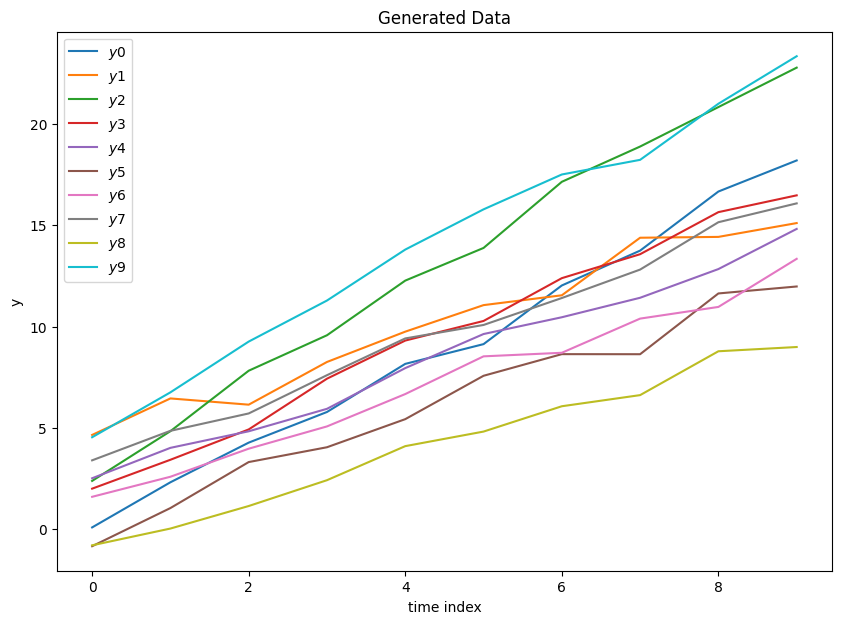

In [ ]:
#---- Test of our population generation ----

# We fix the following parameters

N = 10
k = 10 * np.ones(N, dtype=int)
t = np.array([[j for j in range(k[i])] for i in range(N)])

# theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma)
theta = (0.0, 1.0, 0.3, 1.0, 0.5)

p0 = 0.0
sigma_t0 = 1.0
sigma_v0 = 0.5

y, sampled_params = generate_data(N, t, k, theta, p0, sigma_t0, sigma_v0)

# print("y shape:", y.shape)
# print(sampled_params)

plt.figure(figsize=(10, 7))

# Plots for each individual
for i in range(N):
  plt.plot(np.arange(k[i]), y[i, :], label='$y$' + str(i))
  plt.title('Generated Data')
  plt.xlabel('time index')
  plt.ylabel('y')
  plt.legend()
plt.show()


## **1.B - HM-SAEM - Hasting-Metropolis sampler**

### **Question 3**

In [ ]:
def log_prior_z(z, theta, sigma_t0, sigma_v0, n_ind):
  """
  Log p(z | theta) up to a constant.

  z      : (t0, v0, xi_1..xi_N, tau_1..tau_N)
  theta  : (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  n_ind  : number of individuals
  """
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  t0 = z[0]
  v0 = z[1]
  xi = z[2:2 + n_ind]
  tau = z[2 + n_ind: 2 + 2 * n_ind]

  val = 0.0

  # prior on population effects (t0, v0)
  val += -0.5 * ((t0 - t0_bar) / sigma_t0) ** 2
  val += -0.5 * ((v0 - v0_bar) / sigma_v0) ** 2

  # prior on individual random effects (xi_i, tau_i)
  val += -0.5 * np.sum((xi / sigma_xi) ** 2 + (tau / sigma_tau) ** 2)
  val += -n_ind * np.log(sigma_xi * sigma_tau)

  return val


def observed_log_likelihood(z, theta, y_mat, t_mat, k_vec, p0, n_ind):
  """
  Log p(y | z, theta) up to a constant.

  y_mat, t_mat : shape (n_ind, max_k)
  k_vec        : length n_ind, k_vec[i] = nb of obs for individual i
  """
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  t0 = z[0]
  v0 = z[1]
  xi = z[2:2 + n_ind]
  tau = z[2 + n_ind:2 + 2 * n_ind]

  val = 0.0
  n_total_obs = int(np.sum(k_vec))

  # term -1/2 * sum(log(sigma^2))
  val += -0.5 * n_total_obs * np.log(sigma_obs ** 2)

  for i in range(n_ind):
    t_i = t_mat[i, :k_vec[i]]
    y_i = y_mat[i, :k_vec[i]]

    alpha_i = np.exp(xi[i])
    t_tilde = alpha_i * (t_i - t0 - tau[i]) + t0
    mu_i = d(t_tilde, p0, v0, t0)

    resid = (y_i - mu_i) / sigma_obs
    val += -0.5 * np.sum(resid ** 2)

  return val


def log_posterior_z(z, theta, y_mat, t_mat, k_vec, p0, sigma_t0, sigma_v0, n_ind):
  """
  Log posterior of z up to a constant: log p(z | y, theta).
  """
  return (
      log_prior_z(z, theta, sigma_t0, sigma_v0, n_ind)
      + observed_log_likelihood(z, theta, y_mat, t_mat, k_vec, p0, n_ind)
  )


def log_prior_theta(theta, hyper_params):
  """
  Log p(theta) up to a constant.

  theta        : (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  hyper_params : (t0_bar_bar, v0_bar_bar, s_t0, s_v0,
                  m_xi, m_tau, m, v_xi, v_tau, v)
  """
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma = theta
  (
      t0_bar_bar, v0_bar_bar, s_t0, s_v0,
      m_xi, m_tau, m,
      v_xi, v_tau, v
  ) = hyper_params

  val = 0.0

  # priors on t0_bar, v0_bar
  val += -0.5 * ((t0_bar - t0_bar_bar) / s_t0) ** 2
  val += -0.5 * ((v0_bar - v0_bar_bar) / s_v0) ** 2

  # priors on sigma_xi, sigma_tau, sigma_obs (shrinkage around v_*)
  val += (
      m_xi * np.log(v_xi / sigma_xi)
      - np.log(sigma_xi ** 2)
      - 0.5 * (v_xi / sigma_xi) ** 2
  )

  val += (
      m_tau * np.log(v_tau / sigma_tau)
      - np.log(sigma_tau ** 2)
      - 0.5 * (v_tau / sigma_tau) ** 2
  )

  val += (
      m * np.log(v / sigma)
      - np.log(sigma ** 2)
      - 0.5 * (v / sigma) ** 2
  )
  return val

In [ ]:
def SRW_metropolis_hastings_sampler(z_init, theta, y_mat, t_mat, k_vec,
                                    p0, sigma_t0, sigma_v0,
                                    n_ind, n_iter, proposal_cov):
  """
  Run a Symmetric Random Walk Metropolis–Hastings sampler on z.

  Parameters
  ------
  z_init       : initial state of z, shape (dim_z,)
  theta        : model parameters (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  y_mat, t_mat : data and time grids, shape (n_ind, max_k)
  k_vec        : number of observations per individual, length n_ind
  p0           : intercept in d(t)
  sigma_t0     : std of t0 around t0_bar
  sigma_v0     : std of v0 around v0_bar
  n_ind        : number of individuals
  n_iter       : number of MH iterations
  proposal_cov : proposal covariance for N(z, proposal_cov),
                 shape (dim_z, dim_z)

  Returns
  -------
  samples  : array of shape (n_iter + 1, dim_z), MH trajectory of z
  log_prob : array of shape (n_iter + 1,), log posterior values along the chain
  """
  z = z_init.copy()
  dim_z = z.size

  samples = np.zeros((n_iter + 1, dim_z))
  samples[0] = z

  log_post_z = log_posterior_z(z, theta, y_mat, t_mat, k_vec, p0, sigma_t0, sigma_v0, n_ind)
  log_prob = [log_post_z.copy()]

  for it in range(1, n_iter + 1):
    # proposal
    z_prop = np.random.multivariate_normal(mean=z, cov=proposal_cov)

    # log posterior at proposed point
    log_post_prop = log_posterior_z(
        z_prop, theta, y_mat, t_mat, k_vec, p0, sigma_t0, sigma_v0, n_ind
    )

    # log acceptance ratio
    log_r = log_post_prop - log_post_z

    # accept with prob min(1, exp(log_r))
    if np.log(np.random.rand()) < log_r:
      z = z_prop
      log_post_z = log_post_prop

    log_prob.append(log_post_z)
    samples[it] = z

  return samples, np.array(log_prob)


In [ ]:
#----Test----

np.random.seed(24)

N = 20
k = 10 * np.ones(N, dtype=int)
t = np.array([[j for j in range(k[i])] for i in range(N)])

# theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma)
theta = (0.0, 1.0, 0.3, 1.0, 0.5)
t0_bar = 0.0
v0_bar = 1.0
sigma_xi = 0.3
sigma_tau = 1.0

p0 = 0.0
sigma_t0 = 2.0
sigma_v0 = 2.5

s_t0 = 1
s_v0 = 1


y, sampled_params = generate_data(N, t, k, theta, p0, sigma_t0, sigma_v0)

t0_true = sampled_params["t0"]
v0_true = sampled_params["v0"]

xi = np.random.normal(loc=0, scale= sigma_xi, size=N)
alpha = np.exp(xi)
tau = np.random.normal(loc=0, scale=sigma_tau, size=N)
t0_init = np.array([0.0])
v0_init = np.array([0.0])
z = np.concatenate((t0_init, v0_init, xi, tau))

n_iter_max = 10000
proposal_cov = 0.001 * np.eye(2*N+2)


print(f"Sampling with Symmetric Random Walk Hasting-Metropolis algorithm ...")
samples, log_prob = SRW_metropolis_hastings_sampler(z, theta, y, t, k, p0, sigma_t0, sigma_v0, N, n_iter_max, proposal_cov)
print(f"Sampling with SRW-HM algorithm ended !")

Sampling with Symmetric Random Walk Hasting-Metropolis algorithm ...
Sampling with SRW-HM algorithm ended !


Bias of t0 = [0.00947674]
Bias of v0 = [0.11768956]
RMSE of xi = 0.48219458152554784
RMSE of tau = 1.3543448030253107


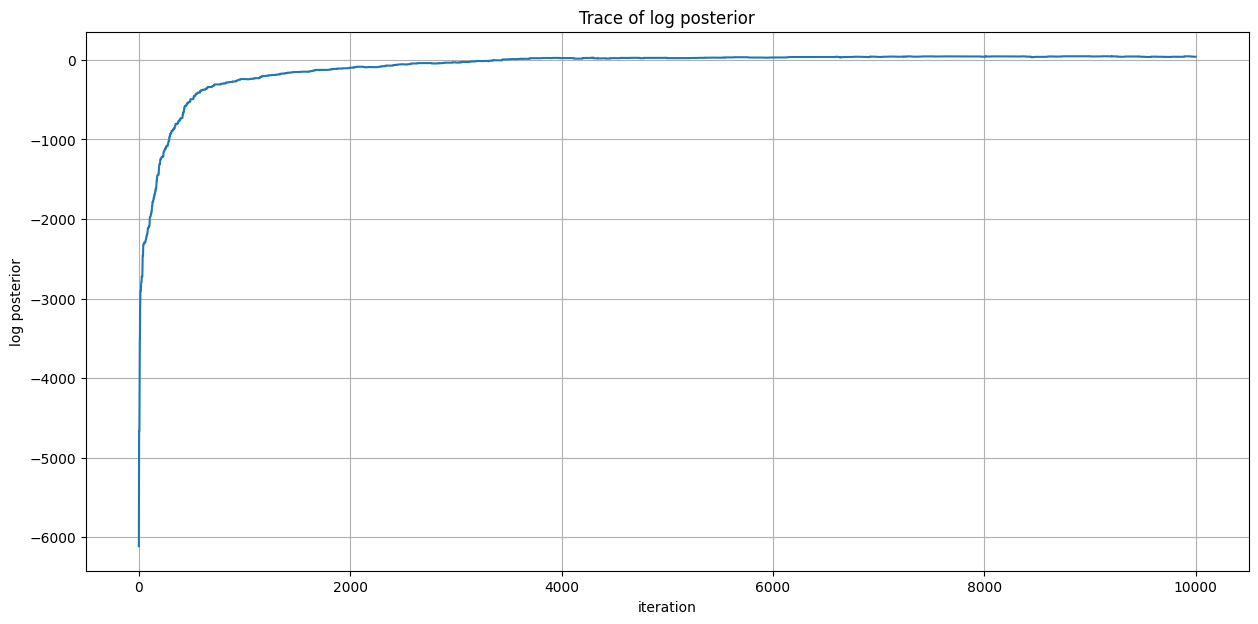

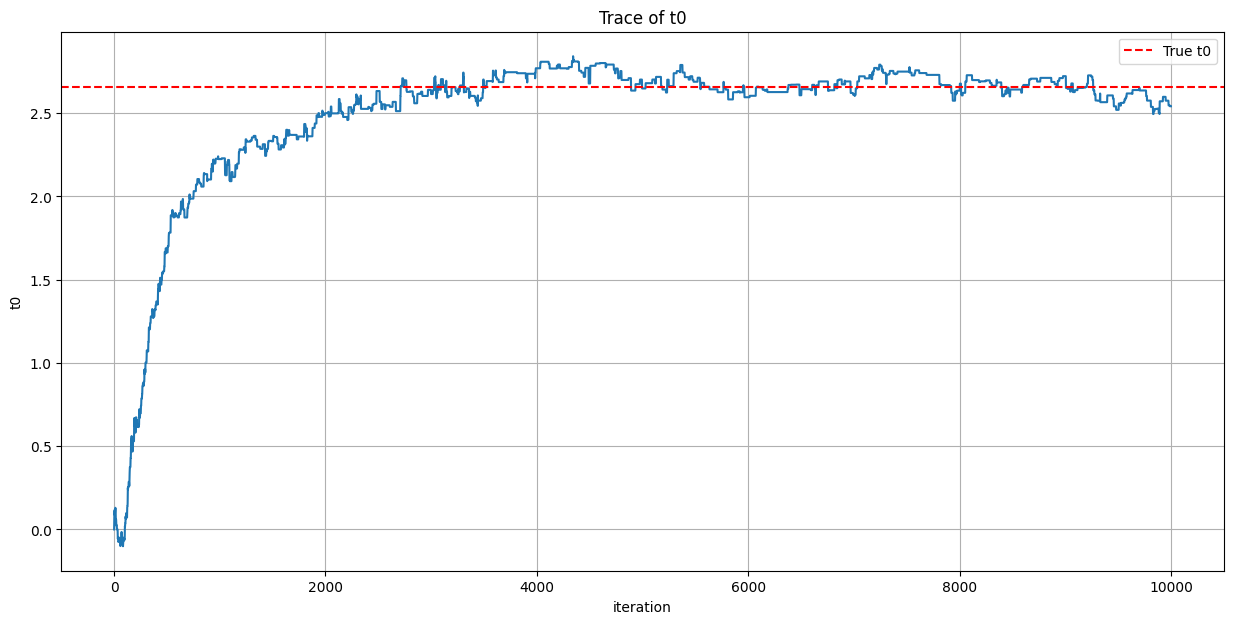

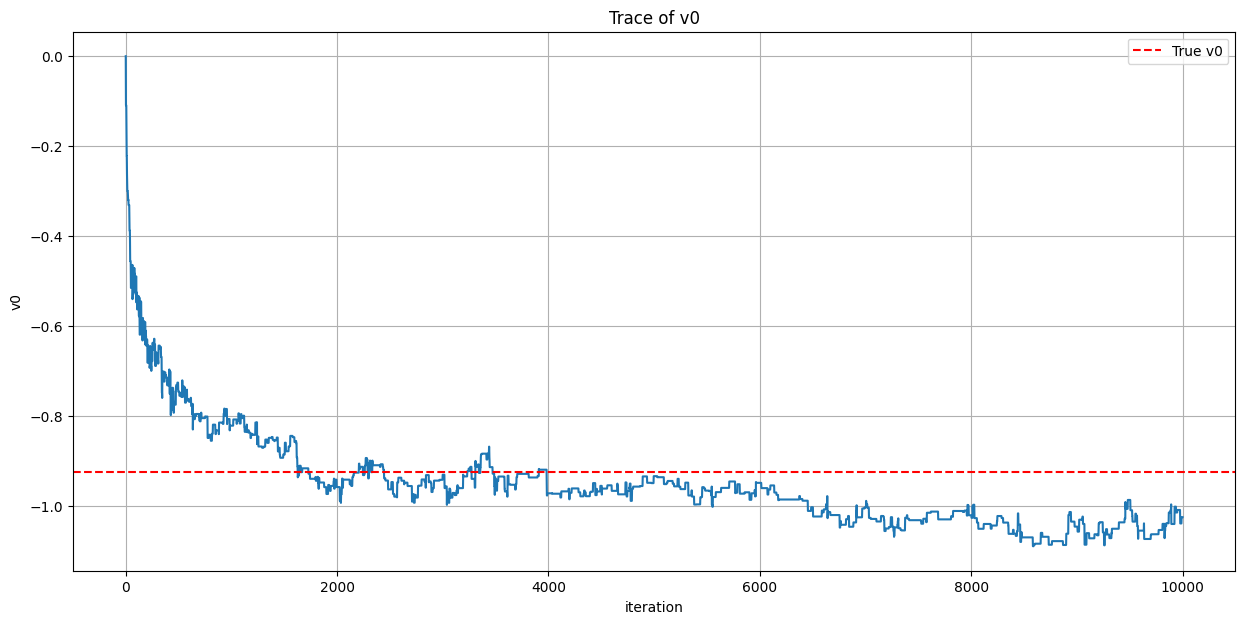

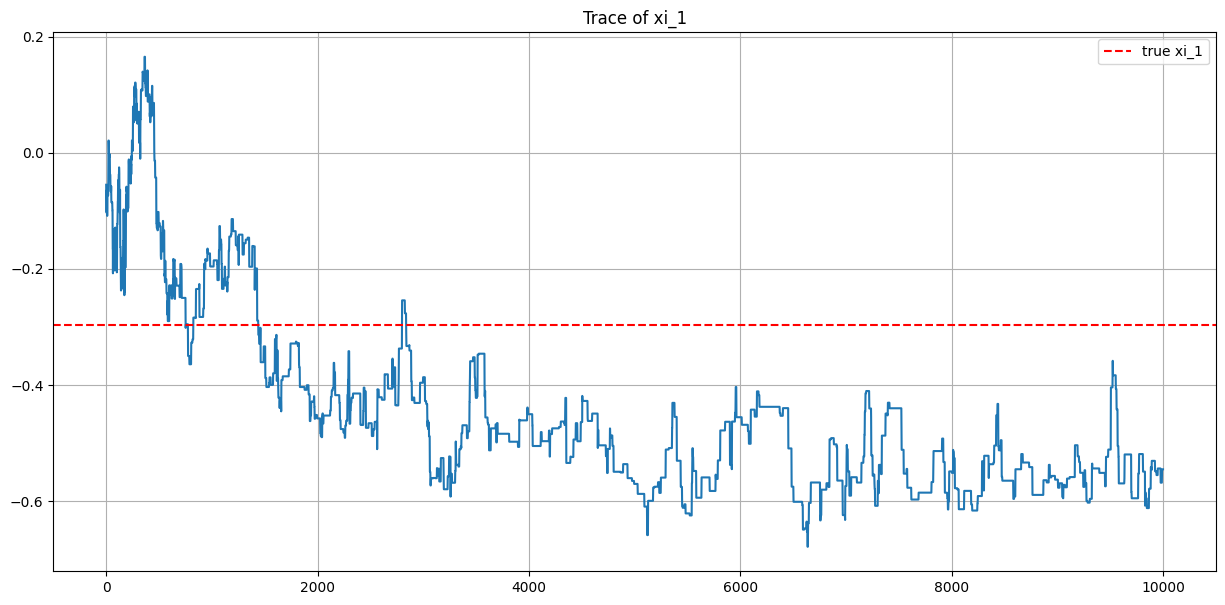

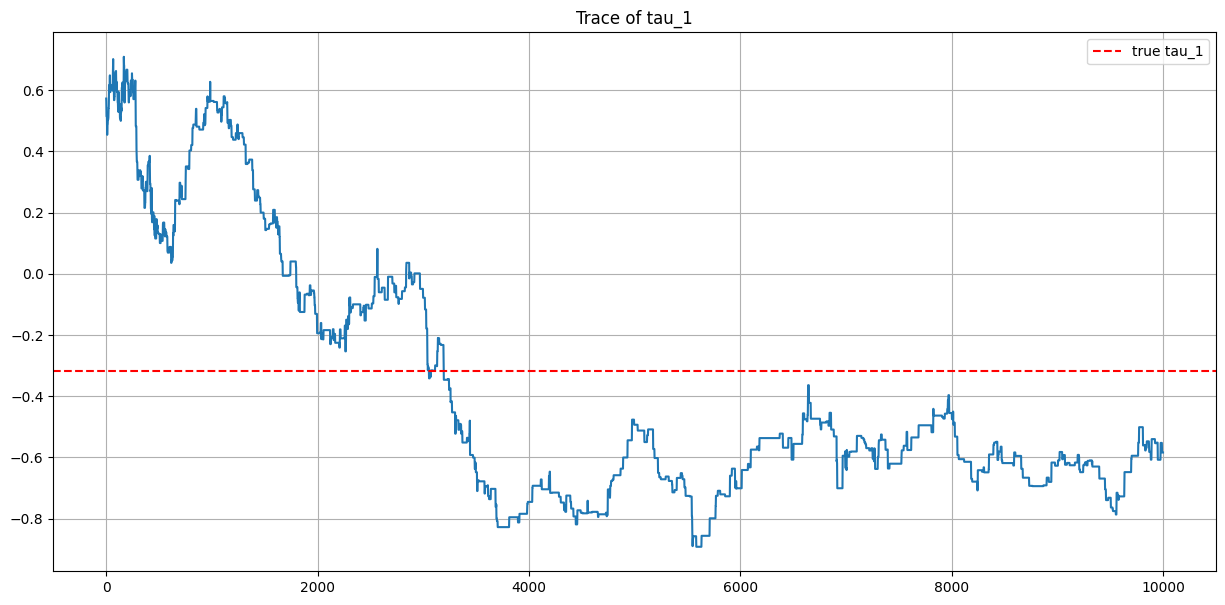

In [ ]:
t0_list = samples[:, 0]
v0_list = samples[:, 1]
xi_list = samples[:, 2:N+2]
tau_list = samples[:, N+2:]

# We check the generated features after burn

burn = int(n_iter_max * 0.7)  #we burn 70% of the samples and keep the last 30%

t0_hat = np.mean(t0_list[burn:], axis = 0)
v0_hat = np.mean(v0_list[burn:], axis = 0)
xi_mean_list = np.mean(xi_list[burn:], axis=0)
tau_mean_list = np.mean(tau_list[burn:], axis=0)

xi_true = sampled_params["xi_true"]
tau_true = sampled_params["tau_true"]

rmse_xi = np.sqrt(np.mean((xi_mean_list - xi_true)**2))
rmse_tau = np.sqrt(np.mean((tau_mean_list - tau_true)**2))

print(f"Bias of t0 = {abs(t0_hat - t0_true)}")
print(f"Bias of v0 = {abs(v0_hat - v0_true)}")
print(f"RMSE of xi = {rmse_xi}")
print(f"RMSE of tau = {rmse_tau}")


plt.figure(figsize=(15, 7))
plt.plot(np.arange(n_iter_max+1), log_prob)
plt.title('Trace of log posterior')
plt.xlabel('iteration')
plt.ylabel('log posterior')
plt.grid()
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(np.arange(n_iter_max+1), t0_list)
plt.title('Trace of t0')
plt.axhline(t0_true, color='r', linestyle='--', label="True t0")
plt.xlabel('iteration')
plt.ylabel('t0')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(np.arange(n_iter_max+1), v0_list)
plt.title('Trace of v0')
plt.axhline(v0_true, color='r', linestyle='--', label="True v0")
plt.xlabel('iteration')
plt.ylabel('v0')
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize=(15, 7))
plt.plot(xi_list[:, 0])
plt.axhline(xi_true[0], color="r", linestyle="--", label="true xi_1")
plt.title(f"Trace of xi_1")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15, 7))
plt.plot(tau_list[:, 0])
plt.axhline(tau_true[0], color="r", linestyle="--", label="true tau_1")
plt.title(f"Trace of tau_1")
plt.legend()
plt.grid()
plt.show()

### **Question 4**

In [ ]:
def step_sizes(alpha_step_size, n_iter, N_b):
  """
  Build SAEM step sizes.
  """
  before_nb = [1 for _ in range(N_b)]
  after_nb = [(k - N_b) ** (-alpha_step_size) for k in range(N_b + 1, n_iter + 1)]
  return np.array(before_nb + after_nb)


def compute_S(y, t, k, z, p0):
  """
  Compute sufficient statistics S(y, z).

  y : (N, max_k), t : (N, max_k), k : (N,)
  z : (2 + 2N,) = (t0, v0, xi_1..xi_N, tau_1..tau_N)
  Returns S = (S1, S2, S3, S4, S5).
  """
  N = len(k)
  t0 = z[0]
  v0 = z[1]
  xi = z[2:N+2]
  tau = z[N+2:]
  alpha = np.exp(xi)

  N_k = int(np.sum(k))

  # S1: mean squared residual
  max_k = t.shape[1]
  mask = (np.arange(max_k)[None, :] < k[:, None])

  t_tilde = alpha[:, None] * (t - t0 - tau[:, None]) + t0
  y_hat = d(t_tilde, p0, v0, t0)

  diff = (y - y_hat) * mask
  sq_res_sum = np.sum(diff ** 2)
  S1 = sq_res_sum / N_k

  # S2: mean of xi_i^2
  S2 = np.mean(xi ** 2)

  # S3: mean of tau_i^2
  S3 = np.mean(tau ** 2)

  # S4, S5: t0, v0
  S4 = t0
  S5 = v0

  return np.array([S1, S2, S3, S4, S5])


def HM_SAEM(theta_0, y_mat, t_mat, k_vec, p0,
            sigma_t0, sigma_v0,
            n_ind, n_iter, proposal_cov, N_b, hyper_params):
  """
  HM-SAEM algorithm for theta and latent z.

  theta_0      : init (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  y_mat, t_mat : data and times, shape (n_ind, max_k)
  Returns (list_S, list_z, theta_est, log_joint_list).
  """
  N = n_ind

  z_0 = np.zeros(2 * N + 2)
  S_0 = np.zeros(5)
  step_sizes_list = step_sizes(0.5, n_iter, N_b)

  z = z_0.copy()
  S = S_0.copy()
  list_z = [z]
  list_S = [S]

  N_k = np.sum(k_vec)

  (t0_bar_bar, v0_bar_bar,
   s_t0_hyp, s_v0_hyp,
   m_xi, m_tau, m,
   v_xi, v_tau, v) = hyper_params

  theta = theta_0.copy()
  list_theta = [theta]
  log_joint_list = []

  n_iter_SRWMH = 50

  for i in range(n_iter):
    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

    # Simulation: z_chain ~ q(.|z)
    z_chain, _ = SRW_metropolis_hastings_sampler(
      z, theta, y_mat, t_mat, k_vec, p0,
      sigma_t0, sigma_v0,
      N, n_iter_SRWMH, proposal_cov
    )
    z = z_chain[-1]
    list_z.append(z.copy())

    # Stochastic Approximation
    S_new = compute_S(y_mat, t_mat, k_vec, z, p0)
    S = S + step_sizes_list[i] * (S_new - S)
    list_S.append(S.copy())

    # Maximization (M-step) for theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)

    # bar_t0
    theta[0] = (sigma_t0**2 * t0_bar_bar + s_t0_hyp**2 * S[3]) / (sigma_t0**2 + s_t0_hyp**2)
    # bar_v0
    theta[1] = (sigma_v0**2 * v0_bar_bar + s_v0_hyp**2 * S[4]) / (sigma_v0**2 + s_v0_hyp**2)

    sigma_xi_sq  = (S[1] * N   + v_xi**2) / (N   + m_xi + 2)
    sigma_tau_sq = (S[2] * N   + v_tau**2) / (N   + m_tau + 2)
    sigma_sq     = (S[0] * N_k + v**2)    / (N_k + m     + 2)

    theta[2] = np.sqrt(sigma_xi_sq)
    theta[3] = np.sqrt(sigma_tau_sq)
    theta[4] = np.sqrt(sigma_sq)

    # log joint
    log_y_given_z = observed_log_likelihood(z, theta, y_mat, t_mat, k_vec, p0, N)
    log_z_given_theta = log_prior_z(z, theta, sigma_t0, sigma_v0, N)
    log_theta = log_prior_theta(theta, hyper_params)
    log_joint = log_y_given_z + log_z_given_theta + log_theta
    log_joint_list.append(log_joint)

    list_theta.append(theta.copy())

  return np.array(list_S), np.array(list_z), np.array(theta), np.array(log_joint_list)


In [ ]:
# ---- Test of HM-SAEM using question 2----
np.random.seed(24)

N = 10
K = 10
k_vec = K * np.ones(N, dtype=int)

t_mat = np.zeros((N, K))
for i in range(N):
    t_mat[i] = np.arange(K)

# theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
t0_bar_true = 0.0
v0_bar_true = 1.0
sigma_xi_true = 0.3
sigma_tau_true = 1.0
sigma_obs_true = 0.5

theta_true = np.array([
    t0_bar_true,
    v0_bar_true,
    sigma_xi_true,
    sigma_tau_true,
    sigma_obs_true
])

# Generation parameters
p0 = 0.0
sigma_t0 = 1.0
sigma_v0 = 0.5

# Data generation
y_mat, sampled_params = generate_data(
    N, t_mat, k_vec,
    theta_true, p0,
    sigma_t0, sigma_v0
)

t0_true = sampled_params["t0"]
v0_true = sampled_params["v0"]

print(f"True latent t0 used for data gen     = {t0_true}")
print(f"True latent v0 used for data gen     = {v0_true}")
print(f"True population theta                = {theta_true}")

# Hyperparameters
t0_bar_bar = 0.0
v0_bar_bar = 1.0
s_t0_hyp = 1.0
s_v0_hyp = 1.0
m_xi = 1.0
m_tau = 1.0
m = 1.0
v_xi = 1.0
v_tau = 1.0
v = 1.0

hyper_params = (
    t0_bar_bar, v0_bar_bar,
    s_t0_hyp, s_v0_hyp,
    m_xi, m_tau, m,
    v_xi, v_tau, v
)

# Initial parameters
# theta_0 = np.array([
#   -1.0,   # bar_t0 init
#    0.0,   # bar_v0 init
#    0.8,   # sigma_xi init
#    0.8,   # sigma_tau init
#    1.0    # sigma_obs init
# ])
theta_0 = theta_true.copy()

# Parameters of SRWMH
s_t0 = 1.0
s_v0 = 1.0
proposal_cov = 0.005 * np.eye(2 * N + 2)

# Parameters of SAEM
n_iter = 1000
N_b = 500  # burn-in parameter for SAEM stepsizes

print("Running HM-SAEM...")
list_S, list_z, theta_est, log_joint_list = HM_SAEM(
    theta_0,
    y_mat,
    t_mat,
    k_vec,
    p0,
    s_t0,
    s_v0,
    N,
    n_iter,
    proposal_cov,
    N_b,
    hyper_params
)

print("HM-SAEM ended !")

True latent t0 used for data gen     = [1.32921217]
True latent v0 used for data gen     = [0.61498327]
True population theta                = [0.  1.  0.3 1.  0.5]
Running HM-SAEM...
HM-SAEM ended !



Final estimated theta (bar_t0, bar_v0, sigma_xi, sigma_tau, sigma_obs):
[0.9545066  0.81570521 0.37787945 1.25410602 0.50787667]

True population theta:
[0.  1.  0.3 1.  0.5]

Posterior mean of latent (t0, v0) on last 30% iterations:
t0_true = [1.32921217],  t0_hat = 2.199360338501231
v0_true = [0.61498327],  v0_hat = 0.7404349701006566

RMSE of xi over individuals = 0.4554
RMSE of xi over individuals = 1.6777


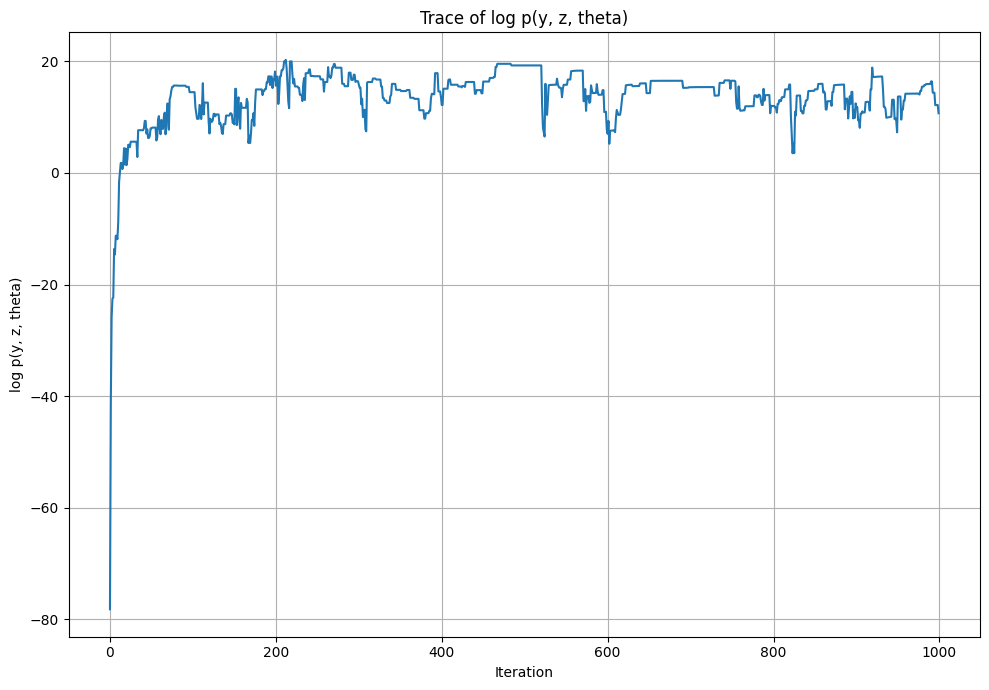

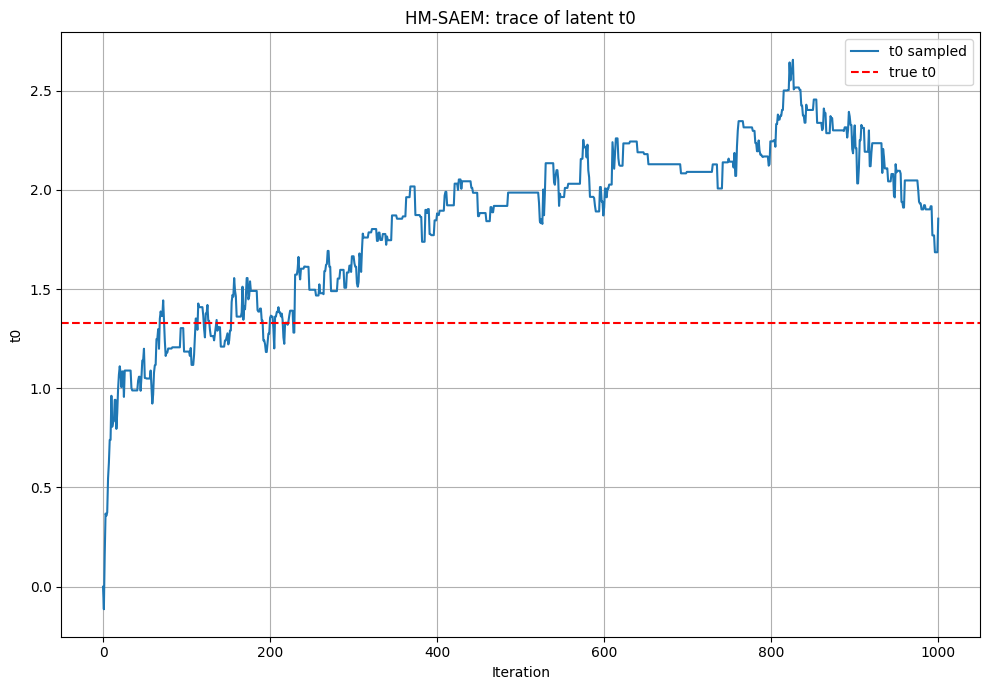

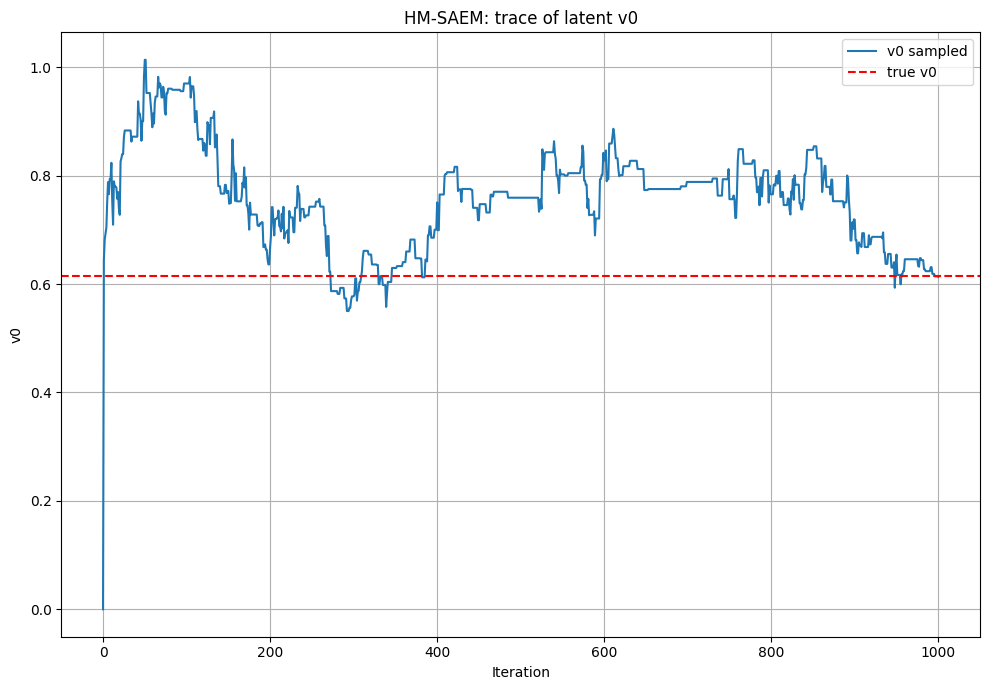

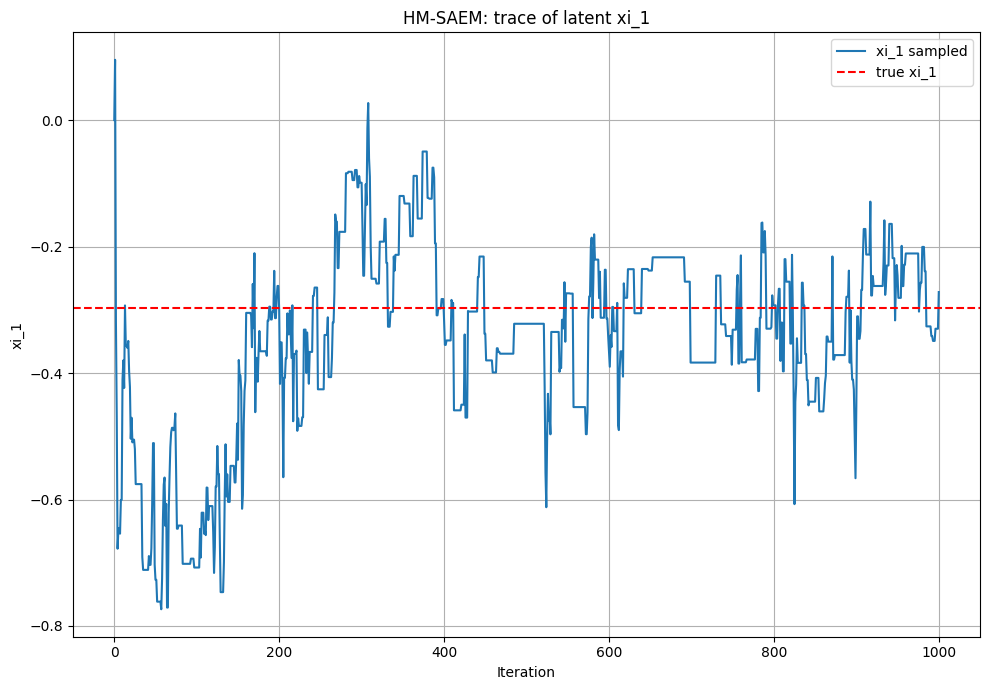

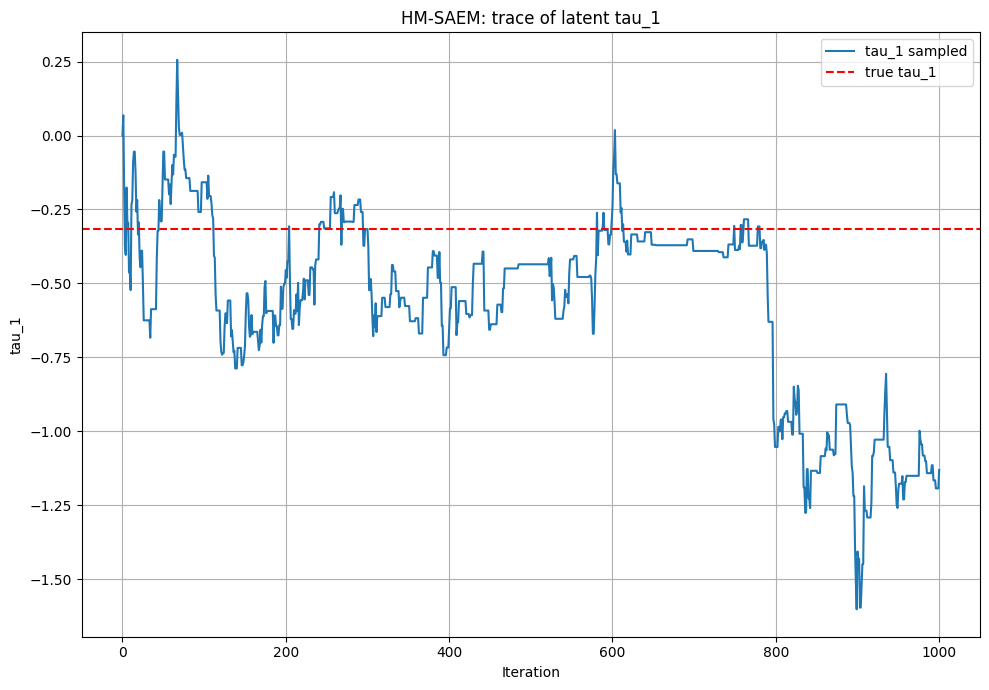

In [ ]:
# Convert paths to arrays
list_S = np.array(list_S)          # shape (n_iter+1, 5)
z_path = np.array(list_z)          # shape (n_iter+1, 2+2N)
its = np.arange(n_iter + 1)

print("\nFinal estimated theta (bar_t0, bar_v0, sigma_xi, sigma_tau, sigma_obs):")
print(theta_est)
print("\nTrue population theta:")
print(theta_true)

# ---- Posterior-like averages for z on the tail of the chain ----
burn_idx = int(0.7 * n_iter)  # keep last 30% as "stationary"
z_post = z_path[burn_idx:, :]
z_mean = z_post.mean(axis=0)

t0_hat = z_mean[0]
v0_hat = z_mean[1]
xi_hat = z_mean[2:2 + N]
tau_hat = z_mean[2 + N:2 + 2 * N]

print("\nPosterior mean of latent (t0, v0) on last 30% iterations:")
print(f"t0_true = {t0_true},  t0_hat = {t0_hat}")
print(f"v0_true = {v0_true},  v0_hat = {v0_hat}")

# RMSE for xi and tau
xi_true = sampled_params["xi_true"]
tau_true = sampled_params["tau_true"]

rmse_xi = np.sqrt(np.mean((xi_hat - xi_true) ** 2))
rmse_tau = np.sqrt(np.mean((tau_hat - tau_true) ** 2))

print(f"\nRMSE of xi over individuals = {rmse_xi:.4f}")
print(f"RMSE of xi over individuals = {rmse_tau:.4f}")

# ---- Plots ----

# Trace of log p(y, z, theta)
plt.figure(figsize=(10, 7))
plt.plot(log_joint_list)
plt.title("Trace of log p(y, z, theta)")
plt.xlabel("Iteration")
plt.ylabel("log p(y, z, theta)")
plt.grid()
plt.tight_layout()
plt.show()

# Trace of latent t0 and v0 from z_path
plt.figure(figsize=(10, 7))
plt.plot(its, z_path[:, 0], label="t0 sampled")
plt.axhline(t0_true, color="r", linestyle="--", label="true t0")
plt.xlabel("Iteration")
plt.ylabel("t0")
plt.title("HM-SAEM: trace of latent t0")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(its, z_path[:, 1], label="v0 sampled")
plt.axhline(v0_true, color="r", linestyle="--", label="true v0")
plt.xlabel("Iteration")
plt.ylabel("v0")
plt.title("HM-SAEM: trace of latent v0")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Trace of xi_1 and tau_1
plt.figure(figsize=(10, 7))
plt.plot(its, z_path[:, 2], label="xi_1 sampled")
plt.axhline(sampled_params["xi_true"][0], color="r", linestyle="--", label="true xi_1")
plt.xlabel("Iteration")
plt.ylabel("xi_1")
plt.title("HM-SAEM: trace of latent xi_1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(its, z_path[:, 2 + N], label="tau_1 sampled")
plt.axhline(sampled_params["tau_true"][0], color="r", linestyle="--", label="true tau_1")
plt.xlabel("Iteration")
plt.ylabel("tau_1")
plt.title("HM-SAEM: trace of latent tau_1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## **1.C - HMwG-SAEM - Hasting-Metropolis within Gibbs sampler**


## **Question 5**

First, we can notice that, by Bayes formula, the full conditionals of $\xi_i$ and $\tau_i$ can be written as

$$
\begin{aligned}
p(\xi_i \mid \tau_i, z_{\text{pop}}, \theta, y)
&= \frac{p(y_i \mid \xi_i,\tau_i,z_{\text{pop}},\theta)\,p(\xi_i \mid \theta)}
{p(y_i \mid \tau_i,z_{\text{pop}},\theta)} \\
&\propto p(y_i \mid \xi_i,\tau_i,z_{\text{pop}},\theta)\,p(\xi_i \mid \theta),
\end{aligned}
$$

$$
\begin{aligned}
p(\tau_i \mid \xi_i, z_{\text{pop}}, \theta, y)
&= \frac{p(y_i \mid \xi_i,\tau_i,z_{\text{pop}},\theta)\,p(\tau_i \mid \theta)}
{p(y_i \mid \xi_i,z_{\text{pop}},\theta)} \\
&\propto p(y_i \mid \xi_i,\tau_i,z_{\text{pop}},\theta)\,p(\tau_i \mid \theta).
\end{aligned}
$$

Using the Gaussian priors of $\xi_i$ and $\tau_i$, we obtain up to a constant:

$$
\log p(\xi_i \mid \tau_i, z_{\text{pop}}, y, \theta)
= -\frac{1}{2\sigma^2}\sum_{j=1}^{k_i}
\bigl(y_{i,j} - d_i(t_{i,j};z_{\text{pop}},\xi_i,\tau_i,\theta)\bigr)^2
-\frac{\xi_i^2}{2\sigma_\xi^2}
$$

$$
\log p(\tau_i \mid \xi_i, z_{\text{pop}}, y, \theta)
= -\frac{1}{2\sigma^2}\sum_{j=1}^{k_i}
\bigl(y_{i,j} - d_i(t_{i,j};z_{\text{pop}},\xi_i,\tau_i,\theta)\bigr)^2
-\frac{\tau_i^2}{2\sigma_\tau^2}
$$

We now construct a Metropolis-Hastings within Gibbs sampler for $z_i = (\xi_i,\tau_i)$ based on these two full conditional distributions.

The Gibbs sampler writes
$$
\begin{align*}
&\text{Given } z_i^{(k)} = (\xi_i^{(k)}, \tau_i^{(k)})\\
1. \quad &\text{Sample } \xi_i^{(k+1)} \sim p(\cdot \mid z_{pop}, y, \theta, \tau_i^{(k)})\\
2. \quad &\text{Sample } \tau_i^{(k+1)} \sim p(\cdot \mid z_{pop}, y, \theta, \xi_i^{(k+1)})
\end{align*}
$$

where we sample the conditional distributions thanks to the HM algorithm separately for $\tau_i$ and $\xi_i$.

Here are the helpers functions that will do this part.

In [ ]:
def log_post_xi(i, zi, z_pop, theta, y_mat, t_mat, k_vec, p0):
  """
  Log posterior (up to const) for xi_i given z_pop, theta, tau_i and individual i's data.

  Parameters
  ----------
  i : int
    index of the individual
  zi : array of shape (2,)
    current (xi_i, tau_i)
  z_pop : array of shape (2,)
    (t0, v0)
  theta : tuple or array
    (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
    t0_bar, v0_bar are not used here but we keep them for consistency
  y_mat, t_mat : arrays (N, max_k)
  k_vec : array (N,)
    number of obs per individual
  p0 : float
    intercept of d(t)
  """
  t0, v0 = z_pop
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  xi_i, tau_i = zi
  log_like = 0.0
  # data for individual i
  k_i = int(k_vec[i])
  y_i = y_mat[i, :k_i]
  t_i = t_mat[i, :k_i]


  alpha_i = np.exp(xi_i)
  t_tilde = alpha_i * (t_i - t0 - tau_i) + t0

  # observed log-likelihood part
  resid = (y_i - d(t_tilde, p0, v0, t0)) / sigma_obs
  log_like += -0.5 * np.sum(resid**2)

  # prior part

  log_like += -0.5 * (xi_i**2 / sigma_xi**2)

  return log_like


def log_post_tau(i, zi, z_pop, theta, y_mat, t_mat, k_vec, p0):
  """
  Log posterior (up to const) for tau_i given z_pop, theta, xi_i and individual i's data.

  Parameters
  ----------
  i : int
    index of the individual
  zi : array of shape (2,)
    current (xi_i, tau_i)
  z_pop : array of shape (2,)
    (t0, v0)
  theta : tuple or array
    (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
    t0_bar, v0_bar are not used here but we keep them for consistency
  y_mat, t_mat : arrays (N, max_k)
  k_vec : array (N,)
    number of obs per individual
  p0 : float
    intercept of d(t)
  """
  t0, v0 = z_pop
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  xi_i, tau_i = zi
  log_like = 0.0
  # data for individual i
  k_i = int(k_vec[i])
  y_i = y_mat[i, :k_i]
  t_i = t_mat[i, :k_i]


  alpha_i = np.exp(xi_i)
  t_tilde = alpha_i * (t_i - t0 - tau_i) + t0

  # observed log-likelihood part
  resid = (y_i - d(t_tilde, p0, v0, t0)) / sigma_obs
  log_like += -0.5 * np.sum(resid**2)

  # prior part

  log_like += -0.5 * (tau_i**2 / sigma_tau**2)

  return log_like

def MH_update_xi(i, zi_current, z_pop, theta,
                 y_mat, t_mat, k_vec, p0, prop_sd):
  """
  One Metropolis-Hastings update for xi_i
  conditionally on z_pop, theta, tau_i and y.

  prop_sd : float
    standard deviation of the random-walk proposal for xi_i
  """
  # zi_current = [xi_i, tau_i]
  zi = zi_current.copy()
  xi_i, tau_i = zi
  accepted = False

  # log posterior at current value
  log_posterior_current = log_post_xi(
      i, zi, z_pop, theta, y_mat, t_mat, k_vec, p0
  )

  # propose a new xi_i (univariate RW)
  xi_new = xi_i + np.random.normal(scale=prop_sd)
  zi_new = np.array([xi_new, tau_i])

  # log posterior at proposed value
  log_posterior_new = log_post_xi(
      i, zi_new, z_pop, theta, y_mat, t_mat, k_vec, p0
  )

  # log-acceptance ratio
  log_r = log_posterior_new - log_posterior_current

  if np.log(np.random.rand()) < log_r:
    accepted = True
    return zi_new, accepted

  # reject, keep old zi
  return zi, accepted


def MH_update_tau(i, zi_current, z_pop, theta,
                  y_mat, t_mat, k_vec, p0, prop_sd):
  """
  One Metropolis-Hastings update for tau_i
  conditionally on z_pop, theta, xi_i and y.

  prop_sd : float
    standard deviation of the random-walk proposal for tau_i
  """
  # zi_current = [xi_i, tau_i]
  zi = zi_current.copy()
  xi_i, tau_i = zi
  accepted = False

  # log posterior at current value
  log_posterior_current = log_post_tau(
      i, zi, z_pop, theta, y_mat, t_mat, k_vec, p0
  )

  # propose a new tau_i (univariate RW)
  tau_new = tau_i + np.random.normal(scale=prop_sd)
  zi_new = np.array([xi_i, tau_new])

  # log posterior at proposed value
  log_posterior_new = log_post_tau(
      i, zi_new, z_pop, theta, y_mat, t_mat, k_vec, p0
  )

  # log-acceptance ratio
  log_r = log_posterior_new - log_posterior_current

  if np.log(np.random.rand()) < log_r:
    accepted = True
    return zi_new, accepted

  # reject, keep old zi
  return zi, accepted


## **Question 6**

First, we can notice that, by Bayes formula, the full conditionals of $t_0$ and $v_0$ can be written as

$$
\begin{aligned}
p(t_0 \mid v_0, z_{\text{ind}}, \theta, y)
&= \frac{p(y \mid t_0,v_0,z_{\text{ind}},\theta)\,p(t_0 \mid \theta)}
{p(y \mid v_0,z_{\text{ind}},\theta)} \\
&\propto p(y \mid t_0,v_0,z_{\text{ind}},\theta)\,p(t_0 \mid \theta),
\end{aligned}
$$

$$
\begin{aligned}
p(v_0 \mid t_0, z_{\text{ind}}, \theta, y)
&= \frac{p(y \mid t_0,v_0,z_{\text{ind}},\theta)\,p(v_0 \mid \theta)}
{p(y \mid t_0,z_{\text{ind}},\theta)} \\
&\propto p(y \mid t_0,v_0,z_{\text{ind}},\theta)\,p(v_0 \mid \theta),
\end{aligned}
$$

where $z_{\text{ind}}=(z_1,\dots,z_N)$ denotes the individual latent effects.
Using the Gaussian priors of $t_0$ and $v_0$, we obtain up to a constant:

$$
\log p(t_0 \mid v_0, z_{\text{ind}}, y, \theta)
= -\frac{1}{2\sigma^2}\sum_{i=1}^N\sum_{j=1}^{k_i}
\bigl(y_{i,j} - d_i(t_{i,j})\bigr)^2
-\frac{(t_0-\bar t_0)^2}{2\sigma_{t_0}^2},
$$

$$
\log p(v_0 \mid t_0, z_{\text{ind}}, y, \theta)
= -\frac{1}{2\sigma^2}\sum_{i=1}^N\sum_{j=1}^{k_i}
\bigl(y_{i,j} - d_i(t_{i,j})\bigr)^2
-\frac{(v_0-\bar v_0)^2}{2\sigma_{v_0}^2},
$$

We now construct a Metropolis–Hastings within Gibbs sampler for $z_{\text{pop}} = (t_0,v_0)$ based on these two full conditional distributions.
The Gibbs sampler writes

$$
\begin{align*}
&\text{Given } z_{\text{pop}}^{(k)} = \bigl(t_0^{(k)}, v_0^{(k)}\bigr)\\
1.\quad &\text{Sample } t_0^{(k+1)} \sim p\bigl(\cdot \mid z_{\text{ind}}, y, \theta, v_0^{(k)}\bigr),\\[0.2cm]
2.\quad &\text{Sample } v_0^{(k+1)} \sim p\bigl(\cdot \mid z_{\text{ind}}, y, \theta, t_0^{(k+1)}\bigr),
\end{align*}
$$

where we sample each of these conditional distributions thanks to the HM algorithm separately for $t_0$ and $v_0$.

Here are the helpers functions that will do this part.

In [ ]:
def log_post_t0(z_i_mat, z_pop, theta, y_mat, t_mat, k_vec, p0, sigma_t0):
  """
  Log posterior (up to const) for t0 given v0, theta, z_i and y for all individuals.

  Parameters
  ----------
  z_i_mat : array of shape (N, 2)
    each row is (xi_i, tau_i)
  z_pop : array of shape (2,)
    (t0, v0)
  theta : array-like
    (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  y_mat, t_mat : arrays (N, max_k)
  k_vec : array (N,)
    number of obs per individual
  p0 : float
    intercept of d(t)
  sigma_t0 : float
    prior std of t0 | t0_bar
  """
  # unpack parameters
  t0, v0 = z_pop
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  N = y_mat.shape[0]
  xi = z_i_mat[:, 0]
  tau = z_i_mat[:, 1]

  # log-likelihood part
  log_like = 0.0
  for i in range(N):
    k_i = int(k_vec[i])
    y_i = y_mat[i, :k_i]
    t_i = t_mat[i, :k_i]

    alpha_i = np.exp(xi[i])
    t_tilde_i = alpha_i * (t_i - t0 - tau[i]) + t0

    resid_i = (y_i - d(t_tilde_i, p0, v0, t0)) / sigma_obs
    log_like += -0.5 * np.sum(resid_i**2)

  # prior: t0 ~ N(t0_bar, sigma_t0^2)
  log_prior = -0.5 * ((t0 - t0_bar) ** 2 / sigma_t0**2)

  return log_like + log_prior


def log_post_v0(z_i_mat, z_pop, theta, y_mat, t_mat, k_vec, p0, sigma_v0):
  """
  Log posterior (up to const) for v0 given t0, theta, z_i and y for all individuals.
  """
  # unpack parameters
  t0, v0 = z_pop
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  N = y_mat.shape[0]
  xi = z_i_mat[:, 0]
  tau = z_i_mat[:, 1]

  # log-likelihood part
  log_like = 0.0
  for i in range(N):
    k_i = int(k_vec[i])
    y_i = y_mat[i, :k_i]
    t_i = t_mat[i, :k_i]

    alpha_i = np.exp(xi[i])
    t_tilde_i = alpha_i * (t_i - t0 - tau[i]) + t0

    resid_i = (y_i - d(t_tilde_i, p0, v0, t0)) / sigma_obs
    log_like += -0.5 * np.sum(resid_i**2)

  # prior: v0 ~ N(v0_bar, sigma_v0^2)
  log_prior = -0.5 * ((v0 - v0_bar) ** 2 / sigma_v0**2)

  return log_like + log_prior


def MH_update_t0(z_pop, z_i_mat, theta,
                 y_mat, t_mat, k_vec, p0,
                 prop_sd, sigma_t0):
  """
  One Metropolis-Hastings update for t0
  conditionally on v0, theta, z_i and y.

  prop_sd : float
    standard deviation of the random-walk proposal for t0
  """
  z_pop = z_pop.copy()
  accepted = False

  t0, v0 = z_pop

  # log posterior at current value
  log_posterior_current = log_post_t0(
      z_i_mat, z_pop, theta, y_mat, t_mat, k_vec, p0, sigma_t0
  )

  # propose a new t0
  t0_new = t0 + np.random.normal(scale=prop_sd)
  z_pop_new = np.array([t0_new, v0])

  # log posterior at proposed value
  log_posterior_new = log_post_t0(
      z_i_mat, z_pop_new, theta, y_mat, t_mat, k_vec, p0, sigma_t0
  )

  # log-acceptance ratio
  log_r = log_posterior_new - log_posterior_current

  if np.log(np.random.rand()) < log_r:
    accepted = True
    return z_pop_new, accepted

  # reject, keep old z_pop
  return z_pop, accepted


def MH_update_v0(z_pop, z_i_mat, theta,
                 y_mat, t_mat, k_vec, p0,
                 prop_sd, sigma_v0):
  """
  One Metropolis-Hastings update for v0
  conditionally on t0, theta, z_i and y.

  prop_sd : float
    standard deviation of the random-walk proposal for v0
  """
  z_pop = z_pop.copy()
  accepted = False

  t0, v0 = z_pop

  # log posterior at current value
  log_posterior_current = log_post_v0(
      z_i_mat, z_pop, theta, y_mat, t_mat, k_vec, p0, sigma_v0
  )

  # propose a new v0
  v0_new = v0 + np.random.normal(scale=prop_sd)
  z_pop_new = np.array([t0, v0_new])

  # log posterior at proposed value
  log_posterior_new = log_post_v0(
      z_i_mat, z_pop_new, theta, y_mat, t_mat, k_vec, p0, sigma_v0
  )

  # log-acceptance ratio
  log_r = log_posterior_new - log_posterior_current

  if np.log(np.random.rand()) < log_r:
    accepted = True
    return z_pop_new, accepted

  # reject
  return z_pop, accepted

## **Question 7**


Combining all the helpers functions that sample using MH, we can implement the HMwG-SAEM algorithm.

In [ ]:
def HMwG_SAEM(theta_0,
              y_mat, t_mat, k_vec,
              p0,
              sigma_t0, sigma_v0,
              n_iter,
              prop_sd_pop_list, prop_sd_indiv_list,
              N_b,
              hyper_params):
  """
  HM-within-Gibbs SAEM to estimate the MAP of theta.

  theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)

  hyper_params = (
    t0_bar_bar, v0_bar_bar, s_t0, s_v0,
    m_xi, m_tau, m,
    v_xi, v_tau, v
  )

  prop_sd_pop   : std of RW proposals for t0 and v0
  prop_sd_indiv : std of RW proposals for xi_i and tau_i
  """
  N = len(k_vec)
  N_k = int(np.sum(k_vec))


  # init latent variables
  z_pop = np.array([0.0, 0.0])        # (t0, v0)
  z_i_mat = np.zeros((N, 2))          # each row (xi_i, tau_i)

  # init stats and step sizes
  S = np.zeros(5)
  eps_list = step_sizes(0.5, n_iter, N_b)

  # unpack hyperparams
  (t0_bar_bar, v0_bar_bar, s_t0, s_v0,
   m_xi, m_tau, m,
   v_xi, v_tau, v) = hyper_params
  prop_sd_t0, prop_sd_v0 = prop_sd_pop_list
  prop_sd_xi, prop_sd_tau = prop_sd_indiv_list

  theta = np.array(theta_0, dtype=float)

  S_path = np.zeros((n_iter + 1, 5))
  theta_path = np.zeros((n_iter + 1, 5))
  z_pop_path = np.zeros((n_iter + 1, 2))
  z_i_path = np.zeros((n_iter + 1, N, 2))

  # store initial state
  S_path[0] = S
  theta_path[0] = theta
  z_pop_path[0] = z_pop
  z_i_path[0] = z_i_mat

  #we compute the acceptance rate for each feature
  count_accept_t0 = 0
  count_accept_v0 = 0
  count_accept_xi = 0
  count_accept_tau = 0

  for k in range(1, n_iter + 1):
    # ==============
    # I) SIMULATION
    # ==============

    # 1. update z_pop = (t0, v0) via MH
    # 1. i) update t0 via MH
    z_pop, accept_t0 = MH_update_t0(
      z_pop, z_i_mat, theta,
      y_mat, t_mat, k_vec, p0,
      prop_sd_t0, sigma_t0
    )
    # 1. ii) update v0, taking into account the previous update of t0
    z_pop, accept_v0 = MH_update_v0(
      z_pop, z_i_mat, theta,
      y_mat, t_mat, k_vec, p0,
      prop_sd_v0, sigma_v0
    )

    # 2. update each z_i = (xi_i, tau_i) via MH-within-Gibbs
    for i in range(N):
      # 2. i) update xi_i
      z_i_mat[i], accept_xi_i = MH_update_xi(
        i, z_i_mat[i], z_pop, theta,
        y_mat, t_mat, k_vec, p0,
        prop_sd_xi
      )
      # 2. ii) update tau_i taking into account the previous sample for xi_i
      z_i_mat[i], accept_tau_i = MH_update_tau(
        i, z_i_mat[i], z_pop, theta,
        y_mat, t_mat, k_vec, p0,
        prop_sd_tau
      )
      if accept_xi_i:
        count_accept_xi += 1
      if accept_tau_i:
        count_accept_tau += 1

    if accept_t0:
      count_accept_t0 += 1
    if accept_v0:
      count_accept_v0 += 1


    # build flat z to compute S
    xi_vec = z_i_mat[:, 0]
    tau_vec = z_i_mat[:, 1]
    z_flat = np.concatenate([z_pop, xi_vec, tau_vec])

    # =========================
    # II) STOCHASTIC APPROX STEP
    # =========================
    S_new = compute_S(y_mat, t_mat, k_vec, z_flat, p0)
    eps = eps_list[k - 1]
    S = S + eps * (S_new - S)

    # =========================
    # III) M STEP
    # =========================

    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

    # update t0_bar, v0_bar
    t0_bar = (sigma_t0**2 * t0_bar_bar + s_t0**2 * S[3]) / (sigma_t0**2 + s_t0**2)
    v0_bar = (sigma_v0**2 * v0_bar_bar + s_v0**2 * S[4]) / (sigma_v0**2 + s_v0**2)

    # update standard deviations
    sigma_xi_sq  = (S[1] * N   + v_xi**2)  / (N   + m_xi  + 2)
    sigma_tau_sq = (S[2] * N   + v_tau**2) / (N   + m_tau + 2)
    sigma_sq     = (S[0] * N_k + v**2)     / (N_k + m     + 2)

    sigma_xi   = np.sqrt(sigma_xi_sq)
    sigma_tau  = np.sqrt(sigma_tau_sq)
    sigma_obs  = np.sqrt(sigma_sq)

    theta = np.array([t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs])

    # store paths
    S_path[k] = S
    theta_path[k] = theta
    z_pop_path[k] = z_pop
    z_i_path[k] = z_i_mat

  acceptance_rate_t0 = count_accept_t0*100/n_iter
  acceptance_rate_v0 = count_accept_v0*100/n_iter
  acceptance_rate_xi = count_accept_xi*100/(n_iter*N)
  acceptance_rate_tau = count_accept_tau*100/(n_iter*N)
  acceptance_rates_list = [acceptance_rate_t0, acceptance_rate_v0, acceptance_rate_xi, acceptance_rate_tau]

  return S_path, theta_path, z_pop_path, z_i_path, acceptance_rates_list

In [ ]:
# ---- Test of HMwG-SAEM ----

np.random.seed(24)

N = 10
K = 10
k_vec = K * np.ones(N, dtype=int)

t_mat = np.zeros((N, K))
for i in range(N):
    t_mat[i] = np.arange(K)

# theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
t0_bar_true = 0.0
v0_bar_true = 1.0
sigma_xi_true = 0.3
sigma_tau_true = 1.0
sigma_obs_true = 0.5

theta_true = np.array([
    t0_bar_true,
    v0_bar_true,
    sigma_xi_true,
    sigma_tau_true,
    sigma_obs_true
])

# Generation parameters
p0 = 0.0
sigma_t0 = 1.0
sigma_v0 = 0.5

# Data generation
y_mat, sampled_params = generate_data(
    N, t_mat, k_vec,
    theta_true, p0,
    sigma_t0, sigma_v0
)

t0_true = sampled_params["t0"]
v0_true = sampled_params["v0"]

print(f"True latent t0 used for data gen     = {t0_true}")
print(f"True latent v0 used for data gen     = {v0_true}")
print(f"True population theta                = {theta_true}")

# Hyperparameters
t0_bar_bar = 0.0
v0_bar_bar = 1.0
s_t0_hyp = 1.0
s_v0_hyp = 1.0
m_xi = 1.0
m_tau = 1.0
m = 1.0
v_xi = 1.0
v_tau = 1.0
v = 1.0

hyper_params = (
    t0_bar_bar, v0_bar_bar,
    s_t0_hyp, s_v0_hyp,
    m_xi, m_tau, m,
    v_xi, v_tau, v
)

# Initial parameters
theta_0 = theta_true.copy()

# MH step sizes
prop_sd_pop_list = [0.3, 0.018]      # for (t0, v0)
prop_sd_indiv_list = [0.2, 0.8]     # for (xi_i, tau_i)

# SAEM parameters
n_iter = 1000
N_b = 500  # burn-in for SAEM stepsizes

print("Running HMwG-SAEM...")
S_path, theta_path, z_pop_path, z_i_path, acceptance_rates_list = HMwG_SAEM(
    theta_0,
    y_mat, t_mat, k_vec,
    p0,
    sigma_t0, sigma_v0,
    n_iter,
    prop_sd_pop_list, prop_sd_indiv_list,
    N_b,
    hyper_params
)
print("HMwG-SAEM ended !")
print(f"List of acceptance rates : {acceptance_rates_list}")

True latent t0 used for data gen     = [1.32921217]
True latent v0 used for data gen     = [0.61498327]
True population theta                = [0.  1.  0.3 1.  0.5]
Running HMwG-SAEM...
HMwG-SAEM ended !
List of acceptance rates : [31.2, 41.5, 33.99, 35.1]


The choice of the proposal standard deviations have been made so that the acceptance rates are around 30~40%.


Final estimated theta (bar_t0, bar_v0, sigma_xi, sigma_tau, sigma_obs):
[0.45724557 0.57630618 0.50801018 0.98069627 0.51165413]

True population theta:
[0.  1.  0.3 1.  0.5]

Posterior mean of latent (t0, v0) on last 30% iterations:
t0_true = [1.32921217],  t0_hat = 1.0460501314120254
v0_true = [0.61498327],  v0_hat = 0.4555014087110633

RMSE of xi over individuals = 0.5412
RMSE of tau over individuals = 1.4041


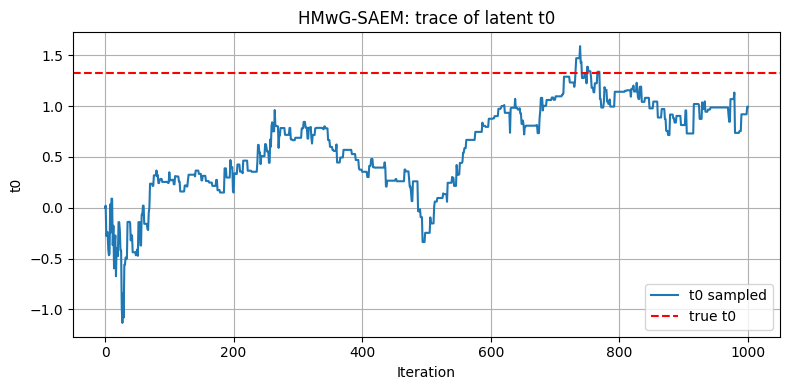

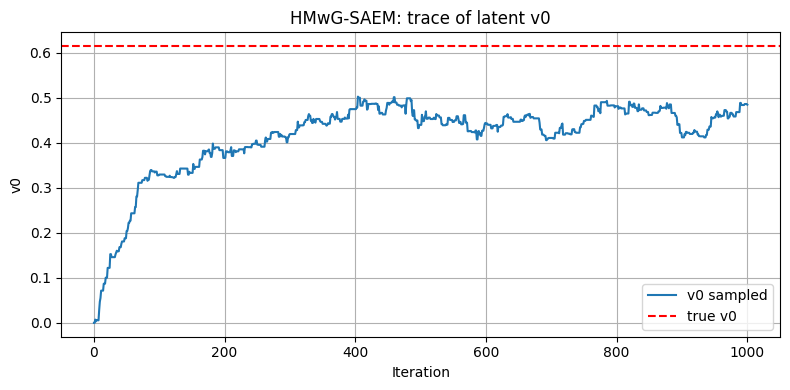

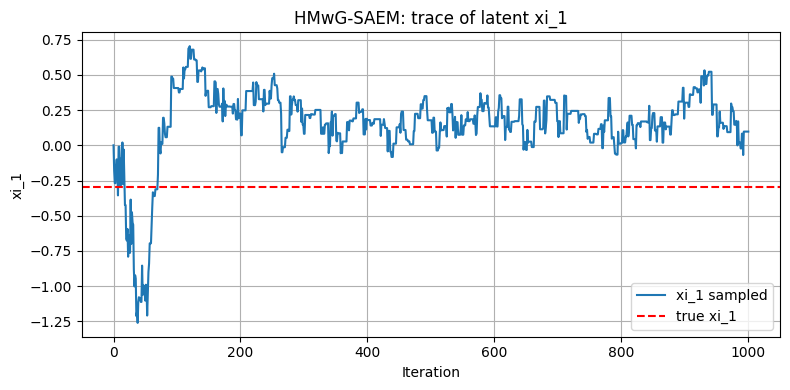

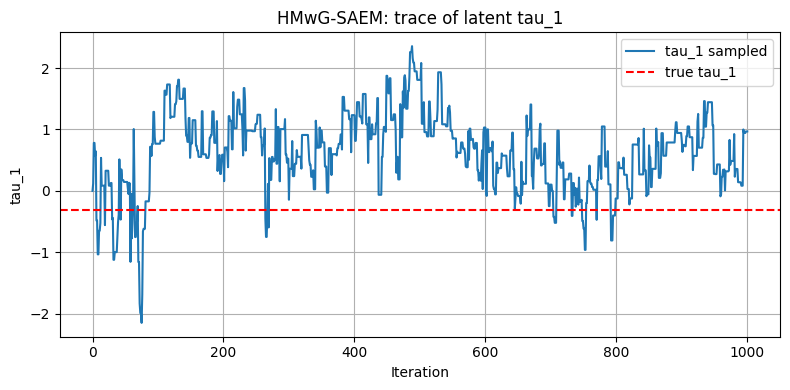

In [ ]:
# Convert paths to arrays
S_path = np.array(S_path)                # (n_iter+1, 5)
theta_path = np.array(theta_path)        # (n_iter+1, 5)
z_pop_path = np.array(z_pop_path)        # (n_iter+1, 2)
z_i_path = np.array(z_i_path)            # (n_iter+1, N, 2)
its = np.arange(n_iter + 1)

theta_est = theta_path[-1]

print("\nFinal estimated theta (bar_t0, bar_v0, sigma_xi, sigma_tau, sigma_obs):")
print(theta_est)
print("\nTrue population theta:")
print(theta_true)

# Rebuild z_path = [t0, v0, xi_1..xi_N, tau_1..tau_N]
z_path = np.zeros((n_iter + 1, 2 + 2 * N))
for k in range(n_iter + 1):
    xi_vec = z_i_path[k, :, 0]
    tau_vec = z_i_path[k, :, 1]
    z_path[k] = np.concatenate([z_pop_path[k], xi_vec, tau_vec])

# Posterior-like averages for z on the tail of the chain
burn_idx = int(0.7 * n_iter)  # keep last 30% as "stationary"
z_post = z_path[burn_idx:, :]
z_mean = z_post.mean(axis=0)

t0_hat = z_mean[0]
v0_hat = z_mean[1]
xi_hat = z_mean[2:2 + N]
tau_hat = z_mean[2 + N:2 + 2 * N]

print("\nPosterior mean of latent (t0, v0) on last 30% iterations:")
print(f"t0_true = {t0_true},  t0_hat = {t0_hat}")
print(f"v0_true = {v0_true},  v0_hat = {v0_hat}")

# RMSE for xi and tau
xi_true = sampled_params["xi_true"]
tau_true = sampled_params["tau_true"]

rmse_xi = np.sqrt(np.mean((xi_hat - xi_true) ** 2))
rmse_tau = np.sqrt(np.mean((tau_hat - tau_true) ** 2))

print(f"\nRMSE of xi over individuals = {rmse_xi:.4f}")
print(f"RMSE of tau over individuals = {rmse_tau:.4f}")

# ---- Plots ----

# Trace of latent t0 and v0 from z_path
plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 0], label="t0 sampled")
plt.axhline(t0_true, color="r", linestyle="--", label="true t0")
plt.xlabel("Iteration")
plt.ylabel("t0")
plt.title("HMwG-SAEM: trace of latent t0")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 1], label="v0 sampled")
plt.axhline(v0_true, color="r", linestyle="--", label="true v0")
plt.xlabel("Iteration")
plt.ylabel("v0")
plt.title("HMwG-SAEM: trace of latent v0")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Trace of xi_1 and tau_1
plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 2], label="xi_1 sampled")
plt.axhline(xi_true[0], color="r", linestyle="--", label="true xi_1")
plt.xlabel("Iteration")
plt.ylabel("xi_1")
plt.title("HMwG-SAEM: trace of latent xi_1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 2 + N], label="tau_1 sampled")
plt.axhline(tau_true[0], color="r", linestyle="--", label="true tau_1")
plt.xlabel("Iteration")
plt.ylabel("tau_1")
plt.title("HMwG-SAEM: trace of latent tau_1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## **Question 8**

In our model the latent variables are strongly correlated a posteriori, so updating them one-by-one makes the chain move slowly along coordinate axes and mix poorly. A Block HMwG sampler updates $(t_0, v_0)$ and each $(\xi_i, \tau_i)$ jointly, which follows the main correlation directions, reduces autocorrelation, and reaches the target distribution much more efficiently (theoreticaly).

## **Question 9**

Instead of updating separately the elements in $z_{\text{pop}}$ and $z_{\text{ind}}$, we can directly update the hole vectors. Indeed, we can remark that with similar computations as before,
$$
p(z_i \mid z_{\text{pop}}, \theta, y_i)
= \frac{p(y_i \mid z_{\text{pop}}, z_i, \theta) p(z_i \mid z_{\text{pop}}, \theta)}{p(y_i)}
\propto p(y \mid z_{\text{pop}}, z_i, \theta) p(z_i \mid \theta),
$$
and
$$
p(z_{\text{pop}} \mid z_i, \theta, y_i)
= \frac{p(y_i \mid z_{\text{pop}}, z_i, \theta) p(z_{\text{pop}} \mid z_i, \theta)}{p(y_i)}
\propto p(y_i \mid z_{\text{pop}}, z_i, \theta) p(z_{\text{pop}} \mid \theta),
$$

where we used the fact that, a priori, $z_i$ is independent of $z_{\text{pop}}$ given $\theta$.


Up to an additive constant in $(\xi_i,\tau_i)$, we have that
$$
\log p(z_i \mid z_{\text{pop}}, y_i, \theta)
= \log p(y_i \mid z_{\text{pop}}, z_i, \theta) + \log p(z_i \mid \theta)
$$

$$
= -\frac{1}{2\sigma^2}\sum_{j=1}^{k_i}\bigl(y_{i,j} - d_i(t_{i,j};z_{\text{pop}},z_i,\theta)\bigr)^2
-\frac{\xi_i^2}{2\sigma_\xi^2}
-\frac{\tau_i^2}{2\sigma_\tau^2}.
$$

and

$$
\log p(z_{\text{pop}} \mid z_i, y_i, \theta)
= \log p(y_i \mid z_{\text{pop}}, z_i, \theta) + \log p(z_{\text{pop}} \mid \theta)
$$

$$
= -\frac{1}{2\sigma^2}\sum_{j=1}^{k_i}\bigl(y_{i,j} - d_i(t_{i,j};z_{\text{pop}},z_i,\theta)\bigr)^2
-\frac{(t_0-\bar t_0)^2}{2\sigma_{t_0}^2}
-\frac{(v_0-\bar v_0)^2}{2\sigma_{v_0}^2}
$$


We now construct a Block Metropolis–Hastings within Gibbs sampler with one block for the fixed effects
$z_{\text{pop}}=(t_0,v_0)$ and one block per individual $z_i=(\xi_i,\tau_i)$, using the above posterior densities.
The Block HMwG sampler writes

$$
\begin{align*}
&\text{Given } z_{\text{pop}}^{(k)},\, z_1^{(k)},\dots,z_N^{(k)}\\[0.2cm]
1.\quad
&\text{Sample } z_{\text{pop}}^{(k+1)} \sim
p\bigl(\cdot \mid z_1^{(k)},\dots,z_N^{(k)},\theta,y\bigr)\\
2.\quad
&\text{For } i = 1 \text{ to } N \text{ do }
\\ & \quad z_i^{(k+1)} \sim p\bigl(\cdot \mid z_{\text{pop}}^{(k+1)},\theta,y_i\bigr),
\end{align*}
$$

where each conditional distribution is sampled by a multivariate Metropolis–Hastings step on the corresponding block (a random–walk proposal in $\mathbb R^2$ for $z_{\text{pop}}$ and for each $z_i$), using respectively
$\log p(z_{\text{pop}} \mid z_i,y_i,\theta)$ and $\log p(z_i \mid z_{\text{pop}},y_i,\theta)$ derived above.

Here are some helpers funnctions that compute the log posterior for the blocks, and do the MH update for a block.

In [ ]:
def log_post_zi(i, zi, z_pop, theta, y_mat, t_mat, k_vec, p0):
  """
  Log posterior (up to const) for z_i = (xi_i, tau_i)
  given z_pop, theta and individual i's data.

  Parameters
  ----------
  i : int
    index of the individual
  zi : array of shape (2,)
    current (xi_i, tau_i)
  z_pop : array of shape (2,)
    (t0, v0)
  theta : tuple or array
    (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
    t0_bar, v0_bar are not used here but we keep them for consistency
  y_mat, t_mat : arrays (N, max_k)
  k_vec : array (N,)
    number of obs per individual
  p0 : float
    intercept of d(t)
  """
  # unpack parameters
  t0, v0 = z_pop
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  xi_i, tau_i = zi

  # data for individual i
  k_i = int(k_vec[i])
  y_i = y_mat[i, :k_i]
  t_i = t_mat[i, :k_i]


  alpha_i = np.exp(xi_i)
  t_tilde = alpha_i * (t_i - t0 - tau_i) + t0

  # observed log-likelihood part
  resid = (y_i - d(t_tilde, p0, v0, t0)) / sigma_obs
  log_like = -0.5 * np.sum(resid**2) - 0.5 * k_i * np.log(sigma_obs**2)

  # prior part: xi_i ~ N(0, sigma_xi^2), tau_i ~ N(0, sigma_tau^2)
  log_prior = -0.5 * (xi_i**2 / sigma_xi**2 + tau_i**2 / sigma_tau**2)

  log_prior += -np.log(sigma_xi * sigma_tau)  # constant in (xi_i, tau_i)

  return log_like + log_prior

def MH_update_zi(i ,zi_current, z_pop, theta, y_mat, t_mat, k_vec, p0, prop_cov):
  """
  One Metropolis-Hastings update for z_i = (xi_i, tau_i),
  conditionally on z_pop, theta and y.
  """
  zi = zi_current.copy()
  accepted = False #flag that tells if we accepted the proposal or no

  log_posterior_current = log_post_zi(i, zi, z_pop, theta, y_mat, t_mat, k_vec, p0)
  zi_new = np.random.multivariate_normal(zi, prop_cov) #proposal

  log_posterior_new = log_post_zi(i, zi_new, z_pop, theta, y_mat, t_mat, k_vec, p0)

  # Compute the log-acceptance ratio
  log_r = log_posterior_new - log_posterior_current

  if np.log(np.random.rand()) < log_r: # we accept
    accepted = True
    return zi_new, accepted
  #we reject
  return zi, accepted


In [ ]:
def log_post_z_pop(z_pop, z_i_mat, theta, y_mat, t_mat, k_vec, p0,
                   sigma_t0, sigma_v0):
  """
  Log posterior (up to const) for z_pop = (t0, v0)
  given all individual z_i, theta, and y.

  Parameters
  ----------
  z_pop : array of shape (2,)
    (t0, v0)
  z_i_mat : array of shape (N, 2)
    each row is (xi_i, tau_i)
  theta : tuple or array
    (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
  y_mat, t_mat : arrays (N, max_k)
  k_vec : array (N,)
    number of obs per individual
  p0 : float
    intercept of d(t)
  sigma_t0, sigma_v0 : floats
    std dev of priors on t0 and v0
  """
  N = len(k_vec)

  t0, v0 = z_pop
  t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

  val = 0.0

  # observed log_likelihood part
  for i in range(N):
    k_i = int(k_vec[i])
    t_i = t_mat[i, :k_i]
    y_i = y_mat[i, :k_i]

    xi_i, tau_i = z_i_mat[i]
    alpha_i = np.exp(xi_i)
    t_tilde = alpha_i * (t_i - t0 - tau_i) + t0
    mu_i = d(t_tilde, p0, v0, t0)

    resid = (y_i - mu_i) / sigma_obs
    val += -0.5 * np.sum(resid ** 2)

  # prior part
  val += -0.5 * ((t0 - t0_bar) / sigma_t0) ** 2
  val += -0.5 * ((v0 - v0_bar) / sigma_v0) ** 2

  return val



def MH_update_z_pop(z_pop, z_i_mat, theta, y_mat, t_mat, k_vec, p0, sigma_t0, sigma_v0, prop_cov):
  """
  One Metropolis-Hastings update for z_pop = (t0, v0),
  conditionally on z_i, theta and y.
  """
  accepted = False
  z_pop_current = z_pop.copy()
  log_post_z_pop_current = log_post_z_pop(z_pop_current, z_i_mat, theta, y_mat, t_mat, k_vec
                                          , p0, sigma_t0, sigma_v0)
  z_pop_new = np.random.multivariate_normal(z_pop_current, prop_cov) #proposal
  log_post_z_pop_new = log_post_z_pop(z_pop_new, z_i_mat, theta, y_mat, t_mat, k_vec
                                          , p0, sigma_t0, sigma_v0)

  #log acceptance rate
  log_r = log_post_z_pop_new - log_post_z_pop_current
  if np.log(np.random.rand()) < log_r: # we accept
    accepted = True
    return z_pop_new, accepted

  return z_pop, accepted


In [ ]:
def Block_HMwG_SAEM(theta_0,
              y_mat, t_mat, k_vec,
              p0,
              sigma_t0, sigma_v0,
              n_iter,
              prop_cov_pop, prop_cov_indiv,
              N_b,
              hyper_params):
  """
  Block Metropolis-Hastings with Gibbs sampler for SAEM using one block for the fixed effects,
  and one block for the individuals.

  Parameters
  ----------

  theta_0 = init for (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)

  hyper_params = (
    t0_bar_bar, v0_bar_bar, s_t0, s_v0,
    m_xi, m_tau, m,
    v_xi, v_tau, v
  )
  """
  N = len(k_vec)
  N_k = int(np.sum(k_vec))

  # init latent variables
  z_pop = np.array([0.0, 0.0])        # (t0, v0)
  z_i_mat = np.zeros((N, 2))          # each row (xi_i, tau_i)

  # init stats and step sizes
  S = np.zeros(5)
  eps_list = step_sizes(0.5, n_iter, N_b)

  # unpack hyperparams
  (t0_bar_bar, v0_bar_bar, s_t0, s_v0,
   m_xi, m_tau, m,
   v_xi, v_tau, v) = hyper_params

  theta = np.array(theta_0, dtype=float)

  S_path = np.zeros((n_iter + 1, 5))
  theta_path = np.zeros((n_iter + 1, 5))
  z_pop_path = np.zeros((n_iter + 1, 2))
  z_i_path = np.zeros((n_iter + 1, N, 2))

  # stock initial state
  S_path[0] = S
  theta_path[0] = theta
  z_pop_path[0] = z_pop
  z_i_path[0] = z_i_mat

  #we compute the acceptance rate for zi and z_pop
  count_accept_zi = 0
  count_accept_v_pop = 0

  for k in range(1, n_iter + 1):
    # ==============
    # I) SIMULATION
    # ==============

    # 1. Update fixed effects block
    z_pop, accept_z_pop = MH_update_z_pop(
      z_pop, z_i_mat, theta,
      y_mat, t_mat, k_vec, p0,
      sigma_t0, sigma_v0,
      prop_cov_pop
    )


    # 2. update each z_i = (xi_i, tau_i)
    for i in range(N):
      # 2. i) update the individuals block
      z_i_mat[i], accept_zi = MH_update_zi(
        i, z_i_mat[i], z_pop, theta,
        y_mat, t_mat, k_vec, p0,
        prop_cov_indiv
      )
      if accept_zi:
        count_accept_zi += 1

    if accept_z_pop:
      count_accept_v_pop += 1

    # flatten z to compute S
    xi_vec = z_i_mat[:, 0]
    tau_vec = z_i_mat[:, 1]
    z_flat = np.concatenate([z_pop, xi_vec, tau_vec])

    # =========================
    # II) STOCHASTIC APPROX
    # =========================
    S_new = compute_S(y_mat, t_mat, k_vec, z_flat, p0)
    eps = eps_list[k - 1]
    S = S + eps * (S_new - S)

    # ============
    # III) M-STEP
    # ============

    # theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs = theta

    # update t0_bar, v0_bar
    t0_bar = (sigma_t0**2 * t0_bar_bar + s_t0**2 * S[3]) / (sigma_t0**2 + s_t0**2)
    v0_bar = (sigma_v0**2 * v0_bar_bar + s_v0**2 * S[4]) / (sigma_v0**2 + s_v0**2)

    # update variances
    sigma_xi_sq = (S[1] * N   + v_xi**2)  / (N   + m_xi + 2)
    sigma_tau_sq = (S[2] * N  + v_tau**2) / (N   + m_tau + 2)
    sigma_sq = (S[0] * N_k    + v**2)     / (N_k + m     + 2)

    sigma_xi = np.sqrt(sigma_xi_sq)
    sigma_tau = np.sqrt(sigma_tau_sq)
    sigma_obs = np.sqrt(sigma_sq)

    theta = np.array([t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs])

    # stocker
    S_path[k] = S
    theta_path[k] = theta
    z_pop_path[k] = z_pop
    z_i_path[k] = z_i_mat

  acceptance_rate_zi = count_accept_zi*100 / (n_iter * N)
  acceptance_rate_z_pop = count_accept_v_pop*100 / n_iter

  acceptance_rates_list = [acceptance_rate_z_pop, acceptance_rate_zi]

  return S_path, theta_path, z_pop_path, z_i_path, acceptance_rates_list


In [ ]:
# ---- Test of Block HMwG-SAEM ----
np.random.seed(24)

N = 10
K = 10
k_vec = K * np.ones(N, dtype=int)

t_mat = np.zeros((N, K))
for i in range(N):
    t_mat[i] = np.arange(K)

# theta = (t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_obs)
t0_bar_true = 0.0
v0_bar_true = 1.0
sigma_xi_true = 0.3
sigma_tau_true = 1.0
sigma_obs_true = 0.5

theta_true = np.array([
    t0_bar_true,
    v0_bar_true,
    sigma_xi_true,
    sigma_tau_true,
    sigma_obs_true
])

# Generation parameters
p0 = 0.0
sigma_t0 = 1.0
sigma_v0 = 0.5

# Data generation
y_mat, sampled_params = generate_data(
    N, t_mat, k_vec,
    theta_true, p0,
    sigma_t0, sigma_v0
)

t0_true = sampled_params["t0"]
v0_true = sampled_params["v0"]

print(f"True latent t0 used for data gen     = {t0_true}")
print(f"True latent v0 used for data gen     = {v0_true}")
print(f"True population theta                = {theta_true}")

# Hyperparameters
t0_bar_bar = 0.0
v0_bar_bar = 1.0
s_t0_hyp = 1.0
s_v0_hyp = 1.0
m_xi = 1.0
m_tau = 1.0
m = 1.0
v_xi = 1.0
v_tau = 1.0
v = 1.0

hyper_params = (
    t0_bar_bar, v0_bar_bar,
    s_t0_hyp, s_v0_hyp,
    m_xi, m_tau, m,
    v_xi, v_tau, v
)

# Initial parameters
theta_0 = theta_true.copy()

# prop_sd_pop_list = [0.2, 0.018]      # for (t0, v0)
# prop_sd_indiv_list = [0.1, 0.8]     # for (xi_i, tau_i)

# Proposal covariances for block MH (2x2)
prop_cov_pop = np.array([[0.002, 0.0005], [0.0005, 0.001]]) # for zpop
prop_cov_indiv = np.array([[0.01, 0.0],[0.0, 0.02]]) # for each zi

# SAEM parameters
n_iter = 1000
N_b = 500  # burn-in for SAEM stepsizes

print("Running Block HMwG-SAEM...")
S_path, theta_path, z_pop_path, z_i_path, acceptance_rates_list = Block_HMwG_SAEM(
    theta_0,
    y_mat, t_mat, k_vec,
    p0,
    sigma_t0, sigma_v0,
    n_iter,
    prop_cov_pop, prop_cov_indiv,
    N_b,
    hyper_params
)
print("Block HMwG-SAEM ended !")
print(f"Acceptance rates list : {acceptance_rates_list}")

True latent t0 used for data gen     = [1.32921217]
True latent v0 used for data gen     = [0.61498327]
True population theta                = [0.  1.  0.3 1.  0.5]
Running Block HMwG-SAEM...
Block HMwG-SAEM ended !
Acceptance rates list : [32.6, 48.4]


The acceptance rates are satisfying. We will next test the algorithm.


Final estimated theta (bar_t0, bar_v0, sigma_xi, sigma_tau, sigma_obs):
[0.63068636 0.82401337 0.38838886 0.97043838 0.51193074]

True population theta:
[0.  1.  0.3 1.  0.5]

Posterior mean of latent (t0, v0) on last 30% iterations:
t0_true = [1.32921217],  t0_hat = 1.1474456549520333
v0_true = [0.61498327],  v0_hat = 0.7278494950942125

RMSE of xi over individuals = 0.4548
RMSE of tau over individuals = 1.3757


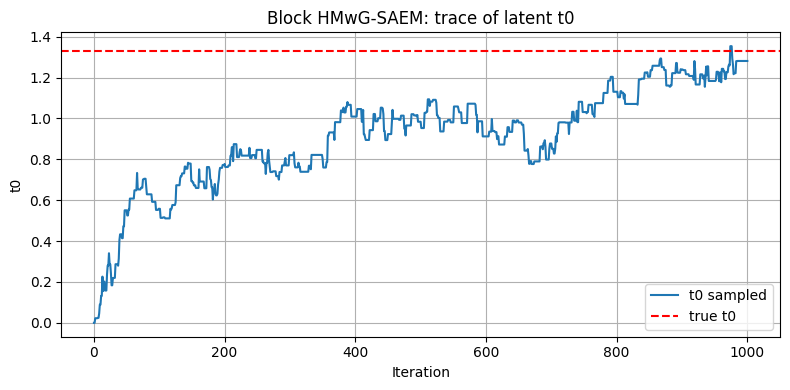

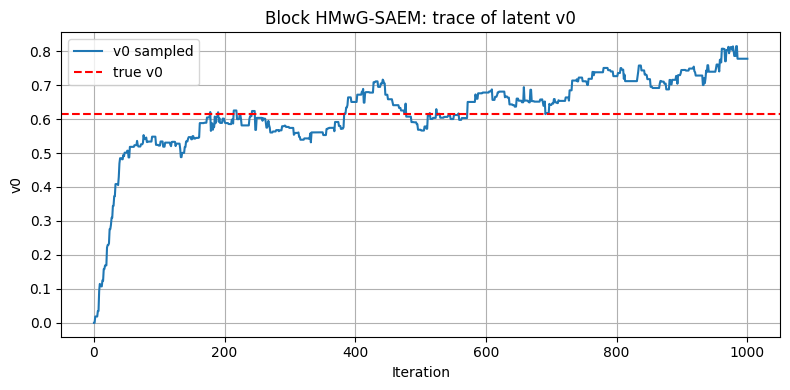

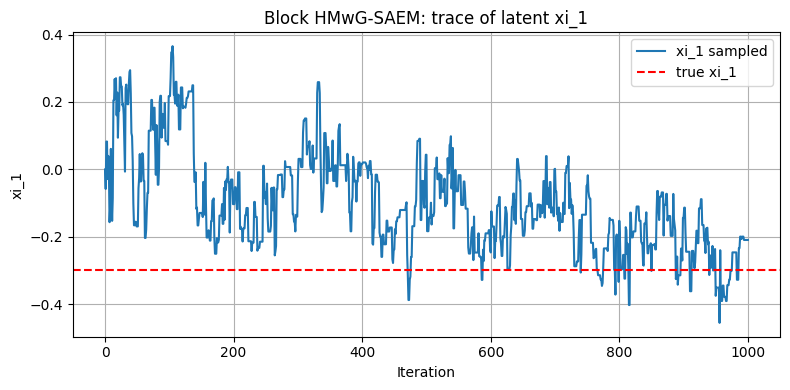

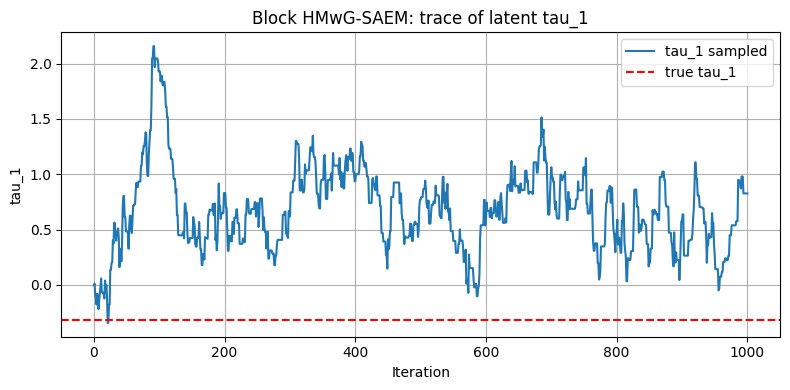

In [ ]:
S_path = np.array(S_path)
theta_path = np.array(theta_path)
z_pop_path = np.array(z_pop_path)
z_i_path = np.array(z_i_path)
its = np.arange(n_iter + 1)

theta_est = theta_path[-1]

print("\nFinal estimated theta (bar_t0, bar_v0, sigma_xi, sigma_tau, sigma_obs):")
print(theta_est)
print("\nTrue population theta:")
print(theta_true)

# Rebuild z_path
z_path = np.zeros((n_iter + 1, 2 + 2 * N))
for k in range(n_iter + 1):
    xi_vec = z_i_path[k, :, 0]
    tau_vec = z_i_path[k, :, 1]
    z_path[k] = np.concatenate([z_pop_path[k], xi_vec, tau_vec])

burn_idx = int(0.7 * n_iter)
z_post = z_path[burn_idx:, :]
z_mean = z_post.mean(axis=0)

t0_hat = z_mean[0]
v0_hat = z_mean[1]
xi_hat = z_mean[2:2 + N]
tau_hat = z_mean[2 + N:2 + 2 * N]

print("\nPosterior mean of latent (t0, v0) on last 30% iterations:")
print(f"t0_true = {t0_true},  t0_hat = {t0_hat}")
print(f"v0_true = {v0_true},  v0_hat = {v0_hat}")

xi_true = sampled_params["xi_true"]
tau_true = sampled_params["tau_true"]

rmse_xi = np.sqrt(np.mean((xi_hat - xi_true) ** 2))
rmse_tau = np.sqrt(np.mean((tau_hat - tau_true) ** 2))

print(f"\nRMSE of xi over individuals = {rmse_xi:.4f}")
print(f"RMSE of tau over individuals = {rmse_tau:.4f}")

# ---- Plots ----

plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 0], label="t0 sampled")
plt.axhline(t0_true, color="r", linestyle="--", label="true t0")
plt.xlabel("Iteration")
plt.ylabel("t0")
plt.title("Block HMwG-SAEM: trace of latent t0")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 1], label="v0 sampled")
plt.axhline(v0_true, color="r", linestyle="--", label="true v0")
plt.xlabel("Iteration")
plt.ylabel("v0")
plt.title("Block HMwG-SAEM: trace of latent v0")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 2], label="xi_1 sampled")
plt.axhline(xi_true[0], color="r", linestyle="--", label="true xi_1")
plt.xlabel("Iteration")
plt.ylabel("xi_1")
plt.title("Block HMwG-SAEM: trace of latent xi_1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(its, z_path[:, 2 + N], label="tau_1 sampled")
plt.axhline(tau_true[0], color="r", linestyle="--", label="true tau_1")
plt.xlabel("Iteration")
plt.ylabel("tau_1")
plt.title("Block HMwG-SAEM: trace of latent tau_1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Here is a table comparing the results for both implementations.

$$
\begin{array}{|l|c|c|c|}
\hline
\textbf{Parameter / Metric} & \textbf{True Value} & \textbf{Component-wise HMwG} & \textbf{Block HMwG} \\
\hline
\bar{t}_0  & 0.0 & \mathbf{0.457} & 0.631 \\
\hline
\bar{v}_0  & 1.0 & 0.576 & \mathbf{0.824} \\
\hline
\sigma_\xi  & 0.3 & 0.508 & \mathbf{0.388} \\
\hline
\sigma_\tau  & 1.0 & \mathbf{0.981} & 0.970 \\
\hline
\sigma_{obs}  & 0.5 & \mathbf{0.5117} & 0.5119 \\
\hline
\text{Latent } t_0  & 1.33 & 1.05 & \mathbf{1.15} \\
\hline
\text{Latent } v_0  & 0.72 & 0.46 & \mathbf{0.73} \\
\hline
\text{RMSE } \xi & 0.0 & 0.5412 & \mathbf{0.4548} \\
\hline
\text{RMSE } \tau  & 0.0 & 1.4041 & \mathbf{1.3757} \\
\hline
\end{array}
$$

Globally, Block HMwG has better results which verifies the theoretical intuition.


# **Exercise 2: Data augmentation**


## **Question 1**

Let $\mathcal F_n = \sigma\big((X_0,Y_0),\dots,(X_n,Y_n)\big)$.
For Borel sets $A\subset \mathbb R^p$ and $B\subset \mathbb R^q$, we start from
$$
\mathbb P\big((X_{n+1},Y_{n+1})\in A\times B \mid \mathcal F_n\big)
  = \mathbb E\big[ \mathbf 1_{\{X_{n+1}\in A,\,Y_{n+1}\in B\}} \mid \mathcal F_n\big].
$$

We first condition with respect to $X_{n+1}$ (tower property):
$$
\begin{aligned}
\mathbb E\big[ \mathbf 1_{\{X_{n+1}\in A,\,Y_{n+1}\in B\}} \mid \mathcal F_n\big]
&= \mathbb E\Big[
      \mathbb E\big[ \mathbf 1_{\{X_{n+1}\in A,\,Y_{n+1}\in B\}}
                     \mid X_{n+1},\mathcal F_n\big]
      \,\Big|\, \mathcal F_n\Big].
\end{aligned}
$$

Given $X_{n+1}$, the variable $Y_{n+1}$ is drawn according to the
conditional density $f_{Y\mid X}(X_{n+1},\cdot)$ and is independent of
$\mathcal F_n$. Hence
$$
\mathbb P\big(Y_{n+1}\in B \mid X_{n+1},\mathcal F_n\big)
  = \int_B f_{Y\mid X}(X_{n+1},y')\,\mathrm dy',
$$
so that
$$
\begin{aligned}
\mathbb E\big[ \mathbf 1_{\{X_{n+1}\in A,\,Y_{n+1}\in B\}} \mid \mathcal F_n\big]
&= \mathbb E\Big[
      \mathbf 1_{\{X_{n+1}\in A\}}
      \int_B f_{Y\mid X}(X_{n+1},y')\,\mathrm dy'
      \,\Big|\,\mathcal F_n\Big].
\end{aligned}
$$

Now we use the way $X_{n+1}$ is generated in the algorithm:
conditionally on $\mathcal F_n$, $X_{n+1}$ is sampled with conditional
density $f_{X\mid Y}(\cdot,Y_n)$, and this depends only on $Y_n$.
Therefore
$$
\begin{aligned}
\mathbb P\big((X_{n+1},Y_{n+1})\in A\times B \mid \mathcal F_n\big)
&= \int_A \left(\int_B f_{Y\mid X}(x',y')\,\mathrm dy'\right)
          f_{X\mid Y}(x',Y_n)\,\mathrm dx'.
\end{aligned}
$$

The right-hand side is a measurable function of $(X_n,Y_n)$ only, so
$(X_n,Y_n)_{n\ge 0}$ is a Markov chain.  
Consequently its transition kernel $Q$ is, for $(x,y)\in\mathbb R^p\times\mathbb R^q$,
$$
Q\big((x,y),A\times B\big)
= \int_A \int_B f_{Y\mid X}(x',y')\,\mathrm dy'\,
                f_{X\mid Y}(x',y)\,\mathrm dx'.
$$

Equivalently, the transition density of $(X_{n+1},Y_{n+1})$ given
$(X_n,Y_n)=(x,y)$ is
$$
k\big((x,y),(x',y')\big)
= f_{X\mid Y}(x',y)\,f_{Y\mid X}(x',y').
$$


## **Question 2**


We now look at the marginal chain $(Y_n)_{n\ge 0}$.
For a Borel set $B\subset\mathbb R^q$,
$$
\mathbb P(Y_{n+1}\in B \mid \mathcal F_n)
= \mathbb E\big[\mathbf 1_{\{Y_{n+1}\in B\}} \mid \mathcal F_n\big].
$$

Again we first condition on $X_{n+1}$, and we get by Tower property:
$$
\begin{aligned}
\mathbb P(Y_{n+1}\in B \mid \mathcal F_n)
&= \mathbb E\Big[
      \mathbb E\big[\mathbf 1_{\{Y_{n+1}\in B\}}
                    \mid X_{n+1},\mathcal F_n\big]
      \,\Big|\,\mathcal F_n\Big].
\end{aligned}
$$

As above, given $X_{n+1}$ the variable $Y_{n+1}$ has density
$f_{Y\mid X}(X_{n+1},\cdot)$, so
$$
\mathbb E\big[\mathbf 1_{\{Y_{n+1}\in B\}}
              \mid X_{n+1},\mathcal F_n\big]
 = \int_B f_{Y\mid X}(X_{n+1},y')\,\mathrm dy',
$$
and therefore
$$
\mathbb P(Y_{n+1}\in B \mid \mathcal F_n)
= \mathbb E\Big[
    \int_B f_{Y\mid X}(X_{n+1},y')\,\mathrm dy'
    \,\Big|\,\mathcal F_n\Big].
$$

Conditionally on $\mathcal F_n$, the law of $X_{n+1}$ is
$f_{X\mid Y}(\cdot,Y_n)$. Using this conditional density we obtain
$$
\mathbb P(Y_{n+1}\in B \mid \mathcal F_n)
=\mathbb P(Y_{n+1}\in B \mid Y_n)= \int_{\mathbb R^p} \int_B f_{Y\mid X}(x',y')\,\mathrm dy'\,
                      f_{X\mid Y}(x',Y_n)\,\mathrm dx'.
$$

This expression depends only on $Y_n$, so $(Y_n)_{n\ge 0}$ is a Markov
chain. Its transition kernel $Q$ is, for $y\in\mathbb R^q$,
$$
Q(y,B)
= \int_{\mathbb R^p} \int_B f_{Y\mid X}(x',y')\,\mathrm dy'\,
                      f_{X\mid Y}(x',y)\,\mathrm dx'.
$$

We now show that the probability measure with density $f_Y$ is invariant
for $Q$. Take a Borel set $B\subset\mathbb R^q$; then
$$
\int_{\mathbb R^q} f_Y(y)\,Q(y,B)\,\mathrm dy
= \int_{\mathbb R^q} f_Y(y)
      \int_{\mathbb R^p} \int_B f_{Y\mid X}(x',y')\,\mathrm dy'\,
                         f_{X\mid Y}(x',y)\,\mathrm dx'
   \,\mathrm dy.
$$

We rearrange the integrals using Fubini:
$$
\int_{\mathbb R^q} f_Y(y)\,Q(y,B)\,\mathrm dy
= \int_B \int_{\mathbb R^p} \int_{\mathbb R^q}
        f_Y(y)\,f_{X\mid Y}(x',y)\,\mathrm dy\,
        f_{Y\mid X}(x',y')\,\mathrm dx'\,\mathrm dy'.
$$

By definition of conditional densities, we have
$f_Y(y)\,f_{X\mid Y}(x',y) = f(x',y)$, the joint density. Hence
$$
\int_{\mathbb R^q} f_Y(y)\,Q(y,B)\,\mathrm dy
= \int_B \int_{\mathbb R^p} \left( \int_{\mathbb R^q} f(x',y)\,\mathrm dy \right)
        f_{Y\mid X}(x',y')\,\mathrm dx'\,\mathrm dy'.
$$

The inner integral gives the marginal $f_X(x')$, so
$$
\int_{\mathbb R^q} f_Y(y)\,Q(y,B)\,\mathrm dy
= \int_B \int_{\mathbb R^p} f_X(x')\,f_{Y\mid X}(x',y')\,\mathrm dx'\,\mathrm dy'.
$$

Using again the definition of conditional density,
$f_X(x')\,f_{Y\mid X}(x',y') = f(x',y')$, so
$$
\int_{\mathbb R^q} f_Y(y)\,Q(y,B)\,\mathrm dy
= \int_B \int_{\mathbb R^p} f(x',y')\,\mathrm dx'\,\mathrm dy'
= \int_B f_Y(y')\,\mathrm dy'.
$$

Thus
$$
\int_{\mathbb R^q} f_Y(y)\,Q(y,B)\,\mathrm dy
= \int_B f_Y(y')\,\mathrm dy',
$$
which shows that the measure with density $f_Y$ is invariant for the
kernel $Q$.


## **Question 3**

Hereafter, we consider the case when

$$
f(x,y) = \frac{4}{\sqrt{2\pi}}\,y^{3/2}\exp\!\Big[-y\Big(\frac{x^{2}}{2}+2\Big)\Big]\mathbf 1_{\mathbb R_+}(y),
\qquad (x,y)\in\mathbb R\times\mathbb R_+ .
$$

We first compute the two full conditional distributions.

**Conditional distribution of $X$ given $Y=y$.**  
For fixed $y>0$,

$$
f_{X\mid Y}(x\mid y)\propto f(x,y)
\propto \exp\!\Big(-\frac{y}{2}x^{2}\Big),
$$

which is the kernel of a centered normal distribution with variance $1/y$.
The normalizing constant is $\sqrt{y/(2\pi)}$, hence

$$
f_{X\mid Y}(x\mid y)
= \sqrt{\frac{y}{2\pi}}\exp\!\Big(-\frac{y}{2}x^{2}\Big),
$$

so

$$
X\mid Y=y \sim \mathcal N\!\Big(0,\frac{1}{y}\Big).
$$

**Conditional distribution of $Y$ given $X=x$.**  
For fixed $x\in\mathbb{R}$,

$$
f_{Y\mid X}(y\mid x)\propto f(x,y)
\propto y^{3/2}\exp\!\Big[-y\Big(2+\frac{x^{2}}{2}\Big)\Big]\mathbf 1_{(0,\infty)}(y).
$$

This is the kernel of a Gamma distribution with shape
$\alpha = 5/2$ and rate $\lambda = 2 + x^{2}/2$. In other words,

$$
Y\mid X=x \sim \mathrm{Gamma}\!\Big(\alpha=\frac{5}{2},\,
\lambda = 2 + \frac{x^{2}}{2}\Big),
$$

that is, with density

$$
f_{Y\mid X}(y\mid x)
= \frac{\lambda^{\alpha}}{\Gamma(\alpha)}\,y^{\alpha-1}
  \exp(-\lambda y)\,\mathbf 1_{(0,\infty)}(y).
$$

Using these two full conditional laws, we can construct a Gibbs sampler
whose invariant distribution is the target density $f$.

---

**Algorithm: Gibbs sampler for the target density $f$**

1. Choose an initial value $y_0>0$ (and optionally $x_0\in\mathbb{R}$)  
   and a number of iterations $N\in\mathbb N$.
2. For $n = 0$ to $N-1$ do
   1. Sample  
      $X_{n+1} \sim \mathcal N\big(0,1/Y_n\big)$.
   2. Sample  
      $Y_{n+1} \sim \mathrm{Gamma}\Big(\alpha=\frac{5}{2},\,
      \lambda = 2 + \frac{X_{n+1}^{2}}{2}\Big)$.
3. Return the chain $\{(X_n,Y_n),\,0\le n\le N\}$.


## **Question 4**

We want to approximate
$$
I := \int_{\mathbb R} \frac{H(x)}{(4+x^2)^{5/2}}\,dx
$$
using the output $\{(X_n,Y_n),0\le n\le N\}$ of the Gibbs sampler.

First compute the marginal density of $X$ under the joint density
$$
f(x,y) = \frac{4}{\sqrt{2\pi}}\,y^{3/2}
\exp\Big[-y\Big(\frac{x^{2}}{2}+2\Big)\Big]\mathbf 1_{(0,\infty)}(y).
$$

For fixed $x\in\mathbb R$,
$$
\begin{aligned}
f_X(x)
&= \int_0^{+\infty} f(x,y)\,dy \\
&= \frac{4}{\sqrt{2\pi}}
   \int_0^{+\infty} y^{3/2}
   \exp\Big[-\Big(2+\frac{x^2}{2}\Big)y\Big]\,dy.
\end{aligned}
$$

Using the Gamma integral
$$
\int_0^{+\infty} y^{\alpha-1} e^{-a y} dy
= \frac{\Gamma(\alpha)}{a^{\alpha}},\quad a>0,
$$
with $\alpha = 5/2$ and $a = 2 + x^2/2$, we get
$$
f_X(x)
= \frac{4}{\sqrt{2\pi}}
  \frac{\Gamma(5/2)}{\big(2+\frac{x^2}{2}\big)^{5/2}}
= \frac{12}{(4+x^2)^{5/2}}.
$$

So
$$
\frac{1}{(4+x^2)^{5/2}} = \frac{1}{12} f_X(x),
$$
and the integral can be rewritten as
$$
I = \int_{\mathbb R} \frac{H(x)}{(4+x^2)^{5/2}}\,dx
  = \frac{1}{12}\int_{\mathbb R} H(x)\,f_X(x)\,dx
  = \frac{1}{12}\,\mathbb E[H(X)],
$$
where $X$ has density $f_X$, i.e. the stationary marginal
distribution of $X_n$ in the Gibbs sampler.

By the ergodic theorem, for large $N$ and after discarding a burn-in
of length $n_0$, we have the Monte Carlo estimator

$$
\frac{1}{N-n_0}\sum_{n=n_0+1}^{N} H(X_n) \xrightarrow[N \to \infty]{a.s} \mathbb E[H(X_1)]
$$

Therefore, a practical estimator of $I$ is
$$
\boxed{
\hat I_N
:= \frac{1}{12} \,
\frac{1}{N-n_0}\sum_{n=n_0+1}^{N} H(X_n)
}
$$
where $(X_n,Y_n)$ comes from the Gibbs sampler and $n_0$ is a chosen
burn-in period.


# **Exercise 3: Multiplicative Hasting-Metropolis**


## **Question 3**

1. We first choose to implement this sampler for the exponential distribution $ \sim \mathcal{E}(\gamma)$ since it can be sampled using the inverse transform method.

2. Then, we choose the Gamma distribution that cannot be sampled from using the inverse transform method.

In [ ]:
#baseline function for both distributions

def mhm_multiplicative(x0, log_pi, n_iter, prop_rate):
    """
    Multiplicative Hastings-Metropolis sampler.

    - x0: initial state > 0
    - log_pi: function x -> log(pi(x)), up to a constant, to compute acceptation ratio
    - n_iter: number of iterations
    - prop_rate: parameter of the exponential distribution espilon.
    """
    x = float(x0)
    samples = np.empty(n_iter + 1)
    samples[0] = x

    accepted_count = 0
    for i in range(1, n_iter + 1):
        # i) Bernoulli(1/2) and epsilon ~ Exp(prop_rate)
        b = np.random.binomial(1, 0.5)
        eps = np.random.exponential(scale=1/prop_rate)

        if b == 1:
            y = eps * x
        else:
            y = x / eps

        # ii) acceptance ratio: pi(y)/pi(x) * q(y,x)/q(x,y) = exp(log_pi(y)-log_pi(x)) * abs(y/x)
        log_ratio = log_pi(y) - log_pi(x) + np.log(abs(y / x))
        ratio = np.exp(log_ratio)
        alpha = min(1.0, ratio)

        u = np.random.rand()
        if u < alpha: #accept
            x = y
            accepted_count += 1
        else:
            x = x

        samples[i] = x

    return samples, (accepted_count*100 / n_iter)


# First distribution : Exponential(gamma)
def log_pi_exp(gamma):
  'Computes the log density of pi(x) = gamma*exp(-gamma*x) up to a constant.'

  return lambda x: -gamma * x

# Second distribution : Gamma(shape, scale)

def log_pi_gamma(shape, scale):
  'Computes the log density of a gamme distribution with parameters (shape, scale) up to a constant.'
  return lambda x: (shape - 1) * np.log(x) - x / scale



## **Question 4**

Acceptance rate of the MHM for the exponential distribution: 38.940
Acceptance rate of the MHM for the gamma distribution : 25.615


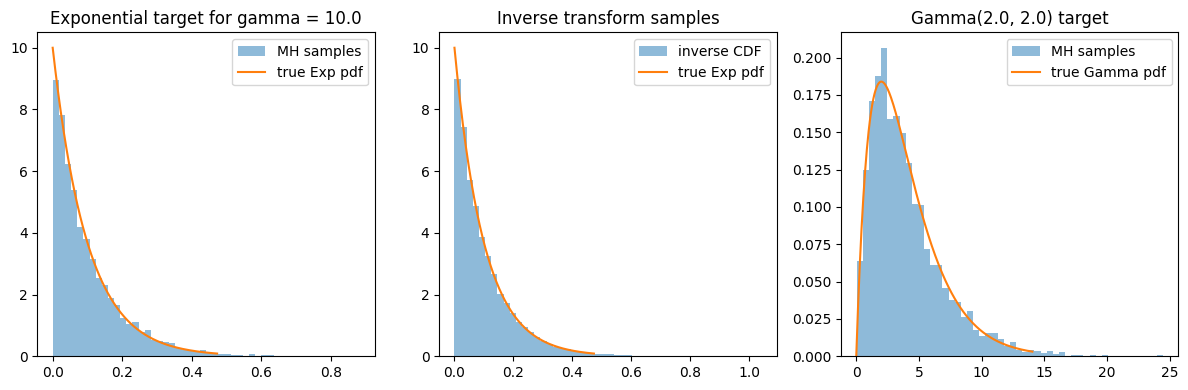

Exponential target for gamma = 10.0:
  empirical mean (MH)   = 0.10311063498884668
  theoretical mean      = 0.1
  empirical variance     = 0.010716446164744802
  theoretical variance      = 0.01

Gamma target for (shape, scale) = (2.0, 2.0)
  empirical mean (MH)   = 4.00531647673814
  theoretical mean      = 4.0
  empirical variance     = 8.650101182264704
  theoretical variance      = 8.0


In [ ]:
# First distribution : Exponential(gamma)
gamma = 10.0
N = 20000
burn_in = 2000
x0 = 1.0
prop_rate = 5.0

samples_exp, acceptance_rate_exp = mhm_multiplicative(x0, log_pi_exp(gamma), N, prop_rate=prop_rate)
samples_exp = samples_exp[burn_in:]

print(f"Acceptance rate of the MHM for the exponential distribution: {acceptance_rate_exp:.3f}")
# True samples with inverse transform method
U = np.random.rand(len(samples_exp))
true_exp_samples = -np.log(1 - U) / gamma


# Second distribution : Gamma(shape, scale)
shape, scale = 2.0, 2.0
samples_gamma, acceptance_rate_gamma = mhm_multiplicative(x0=1.0, log_pi=log_pi_gamma(shape, scale), n_iter=N, prop_rate=prop_rate)
samples_gamma = samples_gamma[burn_in:]
print(f"Acceptance rate of the MHM for the gamma distribution : {acceptance_rate_gamma:.3f}")

def gamma_pdf(x, k, theta):
  "Computes the density of a gamma distribution with parameters (k, theta)"
  return x**(k - 1) * np.exp(-x / theta) / (math.gamma(k) * theta**k)


# Vizualisation with histograms
x_grid = np.linspace(0, np.percentile(samples_exp, 99), 300)
exp_pdf = gamma * np.exp(-gamma * x_grid)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(samples_exp, bins=50, density=True, alpha=0.5, label="MH samples")
plt.plot(x_grid, exp_pdf, label="true Exp pdf")
plt.title(f"Exponential target for gamma = {gamma}")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(true_exp_samples, bins=50, density=True, alpha=0.5, label="inverse CDF")
plt.plot(x_grid, exp_pdf, label="true Exp pdf")
plt.title("Inverse transform samples")
plt.legend()

# Gamma: Plot of the histogram  and the theoretical density function
x_grid_g = np.linspace(0, np.percentile(samples_gamma, 99), 300)
gamma_pdf_vals = gamma_pdf(x_grid_g, shape, scale)

plt.subplot(1, 3, 3)
plt.hist(samples_gamma, bins=50, density=True, alpha=0.5, label="MH samples")
plt.plot(x_grid_g, gamma_pdf_vals, label="true Gamma pdf")
plt.title(f"Gamma({shape}, {scale}) target")
plt.legend()

plt.tight_layout()
plt.show()

# Several statistics for both distributions
print(f"Exponential target for gamma = {gamma}:")
print("  empirical mean (MH)   =", np.mean(samples_exp))
print("  theoretical mean      =", 1.0 / gamma)
print("  empirical variance     =", np.var(samples_exp))
print("  theoretical variance      =", 1.0 / gamma**2)


print(f"\nGamma target for (shape, scale) = {shape, scale}")
print("  empirical mean (MH)   =", np.mean(samples_gamma))
print("  theoretical mean      =", shape * scale)
print("  empirical variance     =", np.var(samples_gamma))
print("  theoretical variance      =", shape * scale**2)


The samples match effectively with the true distribution.